<a href="https://colab.research.google.com/github/SoledadUP/DataFiles/blob/main/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio en clase: Modelos de Ensamble

Este ejercicio tiene como objetivos:

* Aprender a entrenar modelos de ensamble por Votación y Random Forests
* Consolidar el conocimiento del proceso de preparación, ajuste y evaluación de modelos predictivos
* Practicar la optimización de hiperparámetros usando búsqueda aleatoria y búsqueda en grilla
* Visualizar las características más importantes identificadas por Random Forests

# Ensamble por votación manual

## Ejemplo de `scikit-learn`

Como inicio de este ejercicio tomemos una ilustración de la documentación de `scikit-learn`: [Plot the decision boundaries of a VotingClassifier](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html). En ella se diagrama las fronteras de decisión de un modelo de ensamble por votación, usando dos de las cuatro características del [Iris Flower Data Set](https://en.wikipedia.org/wiki/Iris_flower_data_set): largo del sépalo y largo del pétalo.

El conjunto de datos Iris contiene 50 muestras de cada una de tres posibles especies de Iris: *Iris setosa, Iris virginica* e *Iris versicolor*. Para cada muestra se tiene la medida en centímetros de cuatro características: largo y ancho de los pétalos y de los sépalos.

Este modelo por ensamble combina por votación las probabilidades de clase asignadas por tres clasificadores de base: un árbol de decisión (`DecisionTreeClassifier`), un modelo k-NN (`KNeighborsClassifier`), y una máquina de soporte vectorial con kernel gaussiano (`SVC`).

Se ha asignado manualmente a los modelos los pesos `[2, 1, 2]`, lo que significa que, al promediar las probabilidades obtenidas de los modelos, las probabilidades del árbol de decisión y de la máquina de soporte vectorial cuentan el doble que las del modelo k-NN.

In [ ]:
# Adaptado de http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

In [ ]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

%matplotlib inline

In [ ]:
# Cargar el dataset iris
iris = datasets.load_iris()

In [ ]:
iris.data.shape, iris.target.shape

((150, 4), (150,))

In [ ]:
# Usar 2 de los 4 features del dataset iris
X = iris.data[:, [0, 2]]
y = iris.target

In [ ]:
X.shape, y.shape

((150, 2), (150,))

In [ ]:
# Definir modelos de clasificación
model_1 = DecisionTreeClassifier(max_depth=4)
model_2 = KNeighborsClassifier(n_neighbors=7)
model_3 = SVC(gamma=0.1, kernel="rbf", probability=True)

In [ ]:
# Definir el Voting Classifier
ensemble = VotingClassifier(estimators=[("dt", model_1), ("knn", model_2), ("svc", model_3)],
                            voting="soft", weights=[2, 1, 2], n_jobs=-1)

In [ ]:
# Entrenar los modelos
model_1.fit(X, y)
model_2.fit(X, y)
model_3.fit(X, y)
ensemble.fit(X, y)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=4,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
      

In [ ]:
# Construir una matriz en la que graficar
min_X_value_of_first_feature, max_X_value_of_first_feature = X[:, 0].min(), X[:, 0].max()
min_X_value_of_second_feature, max_X_value_of_second_feature = X[:, 1].min(), X[:, 1].max()

x_min, x_max = min_X_value_of_first_feature-1, max_X_value_of_first_feature+1
y_min, y_max = min_X_value_of_second_feature-1, max_X_value_of_second_feature+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

flattened_xx = xx.ravel()
flattened_yy = yy.ravel()

flattened_xx_and_yy_union = np.stack((flattened_xx, flattened_yy), axis=-1)

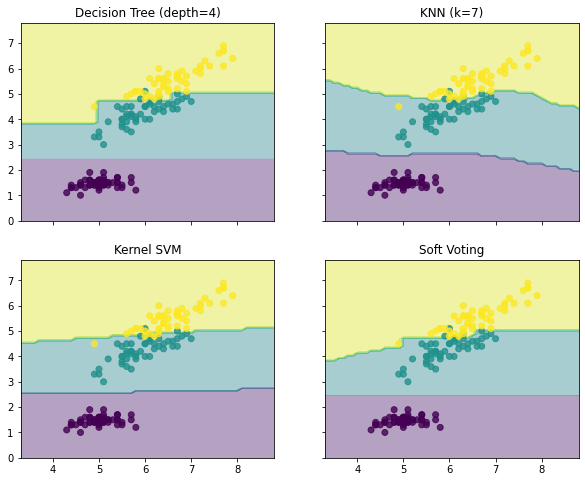

In [ ]:
# Crear el gráfico
fig, axes = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, model, tt in zip(product([0, 1], [0, 1]),
                          [model_1, model_2, model_3, ensemble],
                          ["Decision Tree (depth=4)", "KNN (k=7)", "Kernel SVM", "Soft Voting"]):

    Z = model.predict(flattened_xx_and_yy_union)
    Z = Z.reshape(xx.shape)

    axes[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axes[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axes[idx[0], idx[1]].set_title(tt)

plt.show()

In [ ]:
# Ver las predicciones asignadas por KNN (k=7) a cada clase en cada uno de los últimos 5 ejemplos del conjunto de entrenamiento
last_5_examples = X[-5:]

model_2.predict(last_5_examples)

array([2, 2, 2, 2, 2])

In [ ]:
# Ver las probabilidades de las predicciones asignadas por KNN (k=7) a cada clase en cada uno de los últimos 5 ejemplos del conjunto de entrenamiento
last_5_examples = X[-5:]

model_2.predict_proba(last_5_examples)

array([[0.        , 0.14285714, 0.85714286],
       [0.        , 0.14285714, 0.85714286],
       [0.        , 0.14285714, 0.85714286],
       [0.        , 0.        , 1.        ],
       [0.        , 0.14285714, 0.85714286]])

## Evaluación del modelo de ensamble por votación manual

Observemos la exactitud *(accuracy)* de cada uno los modelos:

In [ ]:
print("Exactitud del modelo de árbol de decisión     :", model_1.score(X, y))
print("Exactitud del modelo de k-NN                  :", model_2.score(X, y))
print("Exactitud del modelo SVM de kernel gaussiano  :", model_3.score(X, y))
print("Exactitud del modelo de ensamble por votación :", ensemble.score(X, y))


Exactitud del modelo de árbol de decisión     : 0.98
Exactitud del modelo de k-NN                  : 0.9666666666666667
Exactitud del modelo SVM de kernel gaussiano  : 0.9533333333333334
Exactitud del modelo de ensamble por votación : 0.98


**Pregunta 1:** ¿A qué crees que se debe que en este caso no se haya llegado a un 100% de exactitud? (sesgo, varianza, error irreducible)

**Pregunta 2:** Dado que los modelos anteriores han sido entrenados en la totalidad de instancias del conjunto de datos Iris, ¿se puede decir que los valores anteriores son buenos indicadores del rendimiento que se tendrá fuera de la muestra (p.ej. en un conjunto de pruebas)?, ¿por qué?

**Pregunta 1:** ...

**Pregunta 2:** ...

# Ensamble por Bagging con Random Forests

En esta parte del ejercicio usaremos el conjunto de datos [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). A partir de un conjunto de características sobre cada pasajero se requiere predecir si sobrevivió o no a la tragedia. Ver la [descripción de los datos](https://www.kaggle.com/c/titanic/data)

En los siguientes pasos tenemos un ejemplo básico del proceso típico de aprendizaje de modelos predictivos.

## Obtención y carga de datos

In [ ]:
#@title Titanic Dataset: train.csv
%%writefile train.csv
PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55,C103,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.05,,S
14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.275,,S
15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14,0,0,350406,7.8542,,S
16,1,2,"Hewlett, Mrs. (Mary D Kingcome) ",female,55,0,0,248706,16,,S
17,0,3,"Rice, Master. Eugene",male,2,4,1,382652,29.125,,Q
18,1,2,"Williams, Mr. Charles Eugene",male,,0,0,244373,13,,S
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)",female,31,1,0,345763,18,,S
20,1,3,"Masselmani, Mrs. Fatima",female,,0,0,2649,7.225,,C
21,0,2,"Fynney, Mr. Joseph J",male,35,0,0,239865,26,,S
22,1,2,"Beesley, Mr. Lawrence",male,34,0,0,248698,13,D56,S
23,1,3,"McGowan, Miss. Anna ""Annie""",female,15,0,0,330923,8.0292,,Q
24,1,1,"Sloper, Mr. William Thompson",male,28,0,0,113788,35.5,A6,S
25,0,3,"Palsson, Miss. Torborg Danira",female,8,3,1,349909,21.075,,S
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)",female,38,1,5,347077,31.3875,,S
27,0,3,"Emir, Mr. Farred Chehab",male,,0,0,2631,7.225,,C
28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263,C23 C25 C27,S
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,,0,0,330959,7.8792,,Q
30,0,3,"Todoroff, Mr. Lalio",male,,0,0,349216,7.8958,,S
31,0,1,"Uruchurtu, Don. Manuel E",male,40,0,0,PC 17601,27.7208,,C
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,,1,0,PC 17569,146.5208,B78,C
33,1,3,"Glynn, Miss. Mary Agatha",female,,0,0,335677,7.75,,Q
34,0,2,"Wheadon, Mr. Edward H",male,66,0,0,C.A. 24579,10.5,,S
35,0,1,"Meyer, Mr. Edgar Joseph",male,28,1,0,PC 17604,82.1708,,C
36,0,1,"Holverson, Mr. Alexander Oskar",male,42,1,0,113789,52,,S
37,1,3,"Mamee, Mr. Hanna",male,,0,0,2677,7.2292,,C
38,0,3,"Cann, Mr. Ernest Charles",male,21,0,0,A./5. 2152,8.05,,S
39,0,3,"Vander Planke, Miss. Augusta Maria",female,18,2,0,345764,18,,S
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14,1,0,2651,11.2417,,C
41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40,1,0,7546,9.475,,S
42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann Wonnacott)",female,27,1,0,11668,21,,S
43,0,3,"Kraeff, Mr. Theodor",male,,0,0,349253,7.8958,,C
44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3,1,2,SC/Paris 2123,41.5792,,C
45,1,3,"Devaney, Miss. Margaret Delia",female,19,0,0,330958,7.8792,,Q
46,0,3,"Rogers, Mr. William John",male,,0,0,S.C./A.4. 23567,8.05,,S
47,0,3,"Lennon, Mr. Denis",male,,1,0,370371,15.5,,Q
48,1,3,"O'Driscoll, Miss. Bridget",female,,0,0,14311,7.75,,Q
49,0,3,"Samaan, Mr. Youssef",male,,2,0,2662,21.6792,,C
50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18,1,0,349237,17.8,,S
51,0,3,"Panula, Master. Juha Niilo",male,7,4,1,3101295,39.6875,,S
52,0,3,"Nosworthy, Mr. Richard Cater",male,21,0,0,A/4. 39886,7.8,,S
53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49,1,0,PC 17572,76.7292,D33,C
54,1,2,"Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkinson)",female,29,1,0,2926,26,,S
55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65,0,1,113509,61.9792,B30,C
56,1,1,"Woolner, Mr. Hugh",male,,0,0,19947,35.5,C52,S
57,1,2,"Rugg, Miss. Emily",female,21,0,0,C.A. 31026,10.5,,S
58,0,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,,C
59,1,2,"West, Miss. Constance Mirium",female,5,1,2,C.A. 34651,27.75,,S
60,0,3,"Goodwin, Master. William Frederick",male,11,5,2,CA 2144,46.9,,S
61,0,3,"Sirayanian, Mr. Orsen",male,22,0,0,2669,7.2292,,C
62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
63,0,1,"Harris, Mr. Henry Birkhardt",male,45,1,0,36973,83.475,C83,S
64,0,3,"Skoog, Master. Harald",male,4,3,2,347088,27.9,,S
65,0,1,"Stewart, Mr. Albert A",male,,0,0,PC 17605,27.7208,,C
66,1,3,"Moubarek, Master. Gerios",male,,1,1,2661,15.2458,,C
67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29,0,0,C.A. 29395,10.5,F33,S
68,0,3,"Crease, Mr. Ernest James",male,19,0,0,S.P. 3464,8.1583,,S
69,1,3,"Andersson, Miss. Erna Alexandra",female,17,4,2,3101281,7.925,,S
70,0,3,"Kink, Mr. Vincenz",male,26,2,0,315151,8.6625,,S
71,0,2,"Jenkin, Mr. Stephen Curnow",male,32,0,0,C.A. 33111,10.5,,S
72,0,3,"Goodwin, Miss. Lillian Amy",female,16,5,2,CA 2144,46.9,,S
73,0,2,"Hood, Mr. Ambrose Jr",male,21,0,0,S.O.C. 14879,73.5,,S
74,0,3,"Chronopoulos, Mr. Apostolos",male,26,1,0,2680,14.4542,,C
75,1,3,"Bing, Mr. Lee",male,32,0,0,1601,56.4958,,S
76,0,3,"Moen, Mr. Sigurd Hansen",male,25,0,0,348123,7.65,F G73,S
77,0,3,"Staneff, Mr. Ivan",male,,0,0,349208,7.8958,,S
78,0,3,"Moutal, Mr. Rahamin Haim",male,,0,0,374746,8.05,,S
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29,,S
80,1,3,"Dowdell, Miss. Elizabeth",female,30,0,0,364516,12.475,,S
81,0,3,"Waelens, Mr. Achille",male,22,0,0,345767,9,,S
82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29,0,0,345779,9.5,,S
83,1,3,"McDermott, Miss. Brigdet Delia",female,,0,0,330932,7.7875,,Q
84,0,1,"Carrau, Mr. Francisco M",male,28,0,0,113059,47.1,,S
85,1,2,"Ilett, Miss. Bertha",female,17,0,0,SO/C 14885,10.5,,S
86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson)",female,33,3,0,3101278,15.85,,S
87,0,3,"Ford, Mr. William Neal",male,16,1,3,W./C. 6608,34.375,,S
88,0,3,"Slocovski, Mr. Selman Francis",male,,0,0,SOTON/OQ 392086,8.05,,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23,3,2,19950,263,C23 C25 C27,S
90,0,3,"Celotti, Mr. Francesco",male,24,0,0,343275,8.05,,S
91,0,3,"Christmann, Mr. Emil",male,29,0,0,343276,8.05,,S
92,0,3,"Andreasson, Mr. Paul Edvin",male,20,0,0,347466,7.8542,,S
93,0,1,"Chaffee, Mr. Herbert Fuller",male,46,1,0,W.E.P. 5734,61.175,E31,S
94,0,3,"Dean, Mr. Bertram Frank",male,26,1,2,C.A. 2315,20.575,,S
95,0,3,"Coxon, Mr. Daniel",male,59,0,0,364500,7.25,,S
96,0,3,"Shorney, Mr. Charles Joseph",male,,0,0,374910,8.05,,S
97,0,1,"Goldschmidt, Mr. George B",male,71,0,0,PC 17754,34.6542,A5,C
98,1,1,"Greenfield, Mr. William Bertram",male,23,0,1,PC 17759,63.3583,D10 D12,C
99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34,0,1,231919,23,,S
100,0,2,"Kantor, Mr. Sinai",male,34,1,0,244367,26,,S
101,0,3,"Petranec, Miss. Matilda",female,28,0,0,349245,7.8958,,S
102,0,3,"Petroff, Mr. Pastcho (""Pentcho"")",male,,0,0,349215,7.8958,,S
103,0,1,"White, Mr. Richard Frasar",male,21,0,1,35281,77.2875,D26,S
104,0,3,"Johansson, Mr. Gustaf Joel",male,33,0,0,7540,8.6542,,S
105,0,3,"Gustafsson, Mr. Anders Vilhelm",male,37,2,0,3101276,7.925,,S
106,0,3,"Mionoff, Mr. Stoytcho",male,28,0,0,349207,7.8958,,S
107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21,0,0,343120,7.65,,S
108,1,3,"Moss, Mr. Albert Johan",male,,0,0,312991,7.775,,S
109,0,3,"Rekic, Mr. Tido",male,38,0,0,349249,7.8958,,S
110,1,3,"Moran, Miss. Bertha",female,,1,0,371110,24.15,,Q
111,0,1,"Porter, Mr. Walter Chamberlain",male,47,0,0,110465,52,C110,S
112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,,C
113,0,3,"Barton, Mr. David John",male,22,0,0,324669,8.05,,S
114,0,3,"Jussila, Miss. Katriina",female,20,1,0,4136,9.825,,S
115,0,3,"Attalah, Miss. Malake",female,17,0,0,2627,14.4583,,C
116,0,3,"Pekoniemi, Mr. Edvard",male,21,0,0,STON/O 2. 3101294,7.925,,S
117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.75,,Q
118,0,2,"Turpin, Mr. William John Robert",male,29,1,0,11668,21,,S
119,0,1,"Baxter, Mr. Quigg Edmond",male,24,0,1,PC 17558,247.5208,B58 B60,C
120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2,4,2,347082,31.275,,S
121,0,2,"Hickman, Mr. Stanley George",male,21,2,0,S.O.C. 14879,73.5,,S
122,0,3,"Moore, Mr. Leonard Charles",male,,0,0,A4. 54510,8.05,,S
123,0,2,"Nasser, Mr. Nicholas",male,32.5,1,0,237736,30.0708,,C
124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13,E101,S
125,0,1,"White, Mr. Percival Wayland",male,54,0,1,35281,77.2875,D26,S
126,1,3,"Nicola-Yarred, Master. Elias",male,12,1,0,2651,11.2417,,C
127,0,3,"McMahon, Mr. Martin",male,,0,0,370372,7.75,,Q
128,1,3,"Madsen, Mr. Fridtjof Arne",male,24,0,0,C 17369,7.1417,,S
129,1,3,"Peter, Miss. Anna",female,,1,1,2668,22.3583,F E69,C
130,0,3,"Ekstrom, Mr. Johan",male,45,0,0,347061,6.975,,S
131,0,3,"Drazenoic, Mr. Jozef",male,33,0,0,349241,7.8958,,C
132,0,3,"Coelho, Mr. Domingos Fernandeo",male,20,0,0,SOTON/O.Q. 3101307,7.05,,S
133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47,1,0,A/5. 3337,14.5,,S
134,1,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29,1,0,228414,26,,S
135,0,2,"Sobey, Mr. Samuel James Hayden",male,25,0,0,C.A. 29178,13,,S
136,0,2,"Richard, Mr. Emile",male,23,0,0,SC/PARIS 2133,15.0458,,C
137,1,1,"Newsom, Miss. Helen Monypeny",female,19,0,2,11752,26.2833,D47,S
138,0,1,"Futrelle, Mr. Jacques Heath",male,37,1,0,113803,53.1,C123,S
139,0,3,"Osen, Mr. Olaf Elon",male,16,0,0,7534,9.2167,,S
140,0,1,"Giglio, Mr. Victor",male,24,0,0,PC 17593,79.2,B86,C
141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,,0,2,2678,15.2458,,C
142,1,3,"Nysten, Miss. Anna Sofia",female,22,0,0,347081,7.75,,S
143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda Dolck)",female,24,1,0,STON/O2. 3101279,15.85,,S
144,0,3,"Burke, Mr. Jeremiah",male,19,0,0,365222,6.75,,Q
145,0,2,"Andrew, Mr. Edgardo Samuel",male,18,0,0,231945,11.5,,S
146,0,2,"Nicholls, Mr. Joseph Charles",male,19,1,1,C.A. 33112,36.75,,S
147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27,0,0,350043,7.7958,,S
148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9,2,2,W./C. 6608,34.375,,S
149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26,F2,S
150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42,0,0,244310,13,,S
151,0,2,"Bateman, Rev. Robert James",male,51,0,0,S.O.P. 1166,12.525,,S
152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22,1,0,113776,66.6,C2,S
153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.05,,S
154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5,,S
155,0,3,"Olsen, Mr. Ole Martin",male,,0,0,Fa 265302,7.3125,,S
156,0,1,"Williams, Mr. Charles Duane",male,51,0,1,PC 17597,61.3792,,C
157,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16,0,0,35851,7.7333,,Q
158,0,3,"Corn, Mr. Harry",male,30,0,0,SOTON/OQ 392090,8.05,,S
159,0,3,"Smiljanic, Mr. Mile",male,,0,0,315037,8.6625,,S
160,0,3,"Sage, Master. Thomas Henry",male,,8,2,CA. 2343,69.55,,S
161,0,3,"Cribb, Mr. John Hatfield",male,44,0,1,371362,16.1,,S
162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Milne)",female,40,0,0,C.A. 33595,15.75,,S
163,0,3,"Bengtsson, Mr. John Viktor",male,26,0,0,347068,7.775,,S
164,0,3,"Calic, Mr. Jovo",male,17,0,0,315093,8.6625,,S
165,0,3,"Panula, Master. Eino Viljami",male,1,4,1,3101295,39.6875,,S
166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9,0,2,363291,20.525,,S
167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,,0,1,113505,55,E33,S
168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45,1,4,347088,27.9,,S
169,0,1,"Baumann, Mr. John D",male,,0,0,PC 17318,25.925,,S
170,0,3,"Ling, Mr. Lee",male,28,0,0,1601,56.4958,,S
171,0,1,"Van der hoef, Mr. Wyckoff",male,61,0,0,111240,33.5,B19,S
172,0,3,"Rice, Master. Arthur",male,4,4,1,382652,29.125,,Q
173,1,3,"Johnson, Miss. Eleanor Ileen",female,1,1,1,347742,11.1333,,S
174,0,3,"Sivola, Mr. Antti Wilhelm",male,21,0,0,STON/O 2. 3101280,7.925,,S
175,0,1,"Smith, Mr. James Clinch",male,56,0,0,17764,30.6958,A7,C
176,0,3,"Klasen, Mr. Klas Albin",male,18,1,1,350404,7.8542,,S
177,0,3,"Lefebre, Master. Henry Forbes",male,,3,1,4133,25.4667,,S
178,0,1,"Isham, Miss. Ann Elizabeth",female,50,0,0,PC 17595,28.7125,C49,C
179,0,2,"Hale, Mr. Reginald",male,30,0,0,250653,13,,S
180,0,3,"Leonard, Mr. Lionel",male,36,0,0,LINE,0,,S
181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S
182,0,2,"Pernot, Mr. Rene",male,,0,0,SC/PARIS 2131,15.05,,C
183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9,4,2,347077,31.3875,,S
184,1,2,"Becker, Master. Richard F",male,1,2,1,230136,39,F4,S
185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4,0,2,315153,22.025,,S
186,0,1,"Rood, Mr. Hugh Roscoe",male,,0,0,113767,50,A32,S
187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,,1,0,370365,15.5,,Q
188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45,0,0,111428,26.55,,S
189,0,3,"Bourke, Mr. John",male,40,1,1,364849,15.5,,Q
190,0,3,"Turcin, Mr. Stjepan",male,36,0,0,349247,7.8958,,S
191,1,2,"Pinsky, Mrs. (Rosa)",female,32,0,0,234604,13,,S
192,0,2,"Carbines, Mr. William",male,19,0,0,28424,13,,S
193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19,1,0,350046,7.8542,,S
194,1,2,"Navratil, Master. Michel M",male,3,1,1,230080,26,F2,S
195,1,1,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44,0,0,PC 17610,27.7208,B4,C
196,1,1,"Lurette, Miss. Elise",female,58,0,0,PC 17569,146.5208,B80,C
197,0,3,"Mernagh, Mr. Robert",male,,0,0,368703,7.75,,Q
198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42,0,1,4579,8.4042,,S
199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,,0,0,370370,7.75,,Q
200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24,0,0,248747,13,,S
201,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28,0,0,345770,9.5,,S
202,0,3,"Sage, Mr. Frederick",male,,8,2,CA. 2343,69.55,,S
203,0,3,"Johanson, Mr. Jakob Alfred",male,34,0,0,3101264,6.4958,,S
204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.225,,C
205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18,0,0,A/5 3540,8.05,,S
206,0,3,"Strom, Miss. Telma Matilda",female,2,0,1,347054,10.4625,G6,S
207,0,3,"Backstrom, Mr. Karl Alfred",male,32,1,0,3101278,15.85,,S
208,1,3,"Albimona, Mr. Nassef Cassem",male,26,0,0,2699,18.7875,,C
209,1,3,"Carr, Miss. Helen ""Ellen""",female,16,0,0,367231,7.75,,Q
210,1,1,"Blank, Mr. Henry",male,40,0,0,112277,31,A31,C
211,0,3,"Ali, Mr. Ahmed",male,24,0,0,SOTON/O.Q. 3101311,7.05,,S
212,1,2,"Cameron, Miss. Clear Annie",female,35,0,0,F.C.C. 13528,21,,S
213,0,3,"Perkin, Mr. John Henry",male,22,0,0,A/5 21174,7.25,,S
214,0,2,"Givard, Mr. Hans Kristensen",male,30,0,0,250646,13,,S
215,0,3,"Kiernan, Mr. Philip",male,,1,0,367229,7.75,,Q
216,1,1,"Newell, Miss. Madeleine",female,31,1,0,35273,113.275,D36,C
217,1,3,"Honkanen, Miss. Eliina",female,27,0,0,STON/O2. 3101283,7.925,,S
218,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42,1,0,243847,27,,S
219,1,1,"Bazzani, Miss. Albina",female,32,0,0,11813,76.2917,D15,C
220,0,2,"Harris, Mr. Walter",male,30,0,0,W/C 14208,10.5,,S
221,1,3,"Sunderland, Mr. Victor Francis",male,16,0,0,SOTON/OQ 392089,8.05,,S
222,0,2,"Bracken, Mr. James H",male,27,0,0,220367,13,,S
223,0,3,"Green, Mr. George Henry",male,51,0,0,21440,8.05,,S
224,0,3,"Nenkoff, Mr. Christo",male,,0,0,349234,7.8958,,S
225,1,1,"Hoyt, Mr. Frederick Maxfield",male,38,1,0,19943,90,C93,S
226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22,0,0,PP 4348,9.35,,S
227,1,2,"Mellors, Mr. William John",male,19,0,0,SW/PP 751,10.5,,S
228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.25,,S
229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18,0,0,236171,13,,S
230,0,3,"Lefebre, Miss. Mathilde",female,,3,1,4133,25.4667,,S
231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35,1,0,36973,83.475,C83,S
232,0,3,"Larsson, Mr. Bengt Edvin",male,29,0,0,347067,7.775,,S
233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59,0,0,237442,13.5,,S
234,1,3,"Asplund, Miss. Lillian Gertrud",female,5,4,2,347077,31.3875,,S
235,0,2,"Leyson, Mr. Robert William Norman",male,24,0,0,C.A. 29566,10.5,,S
236,0,3,"Harknett, Miss. Alice Phoebe",female,,0,0,W./C. 6609,7.55,,S
237,0,2,"Hold, Mr. Stephen",male,44,1,0,26707,26,,S
238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8,0,2,C.A. 31921,26.25,,S
239,0,2,"Pengelly, Mr. Frederick William",male,19,0,0,28665,10.5,,S
240,0,2,"Hunt, Mr. George Henry",male,33,0,0,SCO/W 1585,12.275,,S
241,0,3,"Zabour, Miss. Thamine",female,,1,0,2665,14.4542,,C
242,1,3,"Murphy, Miss. Katherine ""Kate""",female,,1,0,367230,15.5,,Q
243,0,2,"Coleridge, Mr. Reginald Charles",male,29,0,0,W./C. 14263,10.5,,S
244,0,3,"Maenpaa, Mr. Matti Alexanteri",male,22,0,0,STON/O 2. 3101275,7.125,,S
245,0,3,"Attalah, Mr. Sleiman",male,30,0,0,2694,7.225,,C
246,0,1,"Minahan, Dr. William Edward",male,44,2,0,19928,90,C78,Q
247,0,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25,0,0,347071,7.775,,S
248,1,2,"Hamalainen, Mrs. William (Anna)",female,24,0,2,250649,14.5,,S
249,1,1,"Beckwith, Mr. Richard Leonard",male,37,1,1,11751,52.5542,D35,S
250,0,2,"Carter, Rev. Ernest Courtenay",male,54,1,0,244252,26,,S
251,0,3,"Reed, Mr. James George",male,,0,0,362316,7.25,,S
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29,1,1,347054,10.4625,G6,S
253,0,1,"Stead, Mr. William Thomas",male,62,0,0,113514,26.55,C87,S
254,0,3,"Lobb, Mr. William Arthur",male,30,1,0,A/5. 3336,16.1,,S
255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41,0,2,370129,20.2125,,S
256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29,0,2,2650,15.2458,,C
257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,,0,0,PC 17585,79.2,,C
258,1,1,"Cherry, Miss. Gladys",female,30,0,0,110152,86.5,B77,S
259,1,1,"Ward, Miss. Anna",female,35,0,0,PC 17755,512.3292,,C
260,1,2,"Parrish, Mrs. (Lutie Davis)",female,50,0,1,230433,26,,S
261,0,3,"Smith, Mr. Thomas",male,,0,0,384461,7.75,,Q
262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3,4,2,347077,31.3875,,S
263,0,1,"Taussig, Mr. Emil",male,52,1,1,110413,79.65,E67,S
264,0,1,"Harrison, Mr. William",male,40,0,0,112059,0,B94,S
265,0,3,"Henry, Miss. Delia",female,,0,0,382649,7.75,,Q
266,0,2,"Reeves, Mr. David",male,36,0,0,C.A. 17248,10.5,,S
267,0,3,"Panula, Mr. Ernesti Arvid",male,16,4,1,3101295,39.6875,,S
268,1,3,"Persson, Mr. Ernst Ulrik",male,25,1,0,347083,7.775,,S
269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58,0,1,PC 17582,153.4625,C125,S
270,1,1,"Bissette, Miss. Amelia",female,35,0,0,PC 17760,135.6333,C99,S
271,0,1,"Cairns, Mr. Alexander",male,,0,0,113798,31,,S
272,1,3,"Tornquist, Mr. William Henry",male,25,0,0,LINE,0,,S
273,1,2,"Mellinger, Mrs. (Elizabeth Anne Maidment)",female,41,0,1,250644,19.5,,S
274,0,1,"Natsch, Mr. Charles H",male,37,0,1,PC 17596,29.7,C118,C
275,1,3,"Healy, Miss. Hanora ""Nora""",female,,0,0,370375,7.75,,Q
276,1,1,"Andrews, Miss. Kornelia Theodosia",female,63,1,0,13502,77.9583,D7,S
277,0,3,"Lindblom, Miss. Augusta Charlotta",female,45,0,0,347073,7.75,,S
278,0,2,"Parkes, Mr. Francis ""Frank""",male,,0,0,239853,0,,S
279,0,3,"Rice, Master. Eric",male,7,4,1,382652,29.125,,Q
280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35,1,1,C.A. 2673,20.25,,S
281,0,3,"Duane, Mr. Frank",male,65,0,0,336439,7.75,,Q
282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28,0,0,347464,7.8542,,S
283,0,3,"de Pelsmaeker, Mr. Alfons",male,16,0,0,345778,9.5,,S
284,1,3,"Dorking, Mr. Edward Arthur",male,19,0,0,A/5. 10482,8.05,,S
285,0,1,"Smith, Mr. Richard William",male,,0,0,113056,26,A19,S
286,0,3,"Stankovic, Mr. Ivan",male,33,0,0,349239,8.6625,,C
287,1,3,"de Mulder, Mr. Theodore",male,30,0,0,345774,9.5,,S
288,0,3,"Naidenoff, Mr. Penko",male,22,0,0,349206,7.8958,,S
289,1,2,"Hosono, Mr. Masabumi",male,42,0,0,237798,13,,S
290,1,3,"Connolly, Miss. Kate",female,22,0,0,370373,7.75,,Q
291,1,1,"Barber, Miss. Ellen ""Nellie""",female,26,0,0,19877,78.85,,S
292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19,1,0,11967,91.0792,B49,C
293,0,2,"Levy, Mr. Rene Jacques",male,36,0,0,SC/Paris 2163,12.875,D,C
294,0,3,"Haas, Miss. Aloisia",female,24,0,0,349236,8.85,,S
295,0,3,"Mineff, Mr. Ivan",male,24,0,0,349233,7.8958,,S
296,0,1,"Lewy, Mr. Ervin G",male,,0,0,PC 17612,27.7208,,C
297,0,3,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,,C
298,0,1,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S
299,1,1,"Saalfeld, Mr. Adolphe",male,,0,0,19988,30.5,C106,S
300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50,0,1,PC 17558,247.5208,B58 B60,C
301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,,0,0,9234,7.75,,Q
302,1,3,"McCoy, Mr. Bernard",male,,2,0,367226,23.25,,Q
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19,0,0,LINE,0,,S
304,1,2,"Keane, Miss. Nora A",female,,0,0,226593,12.35,E101,Q
305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,,0,0,A/5 2466,8.05,,S
306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S
307,1,1,"Fleming, Miss. Margaret",female,,0,0,17421,110.8833,,C
308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)",female,17,1,0,PC 17758,108.9,C65,C
309,0,2,"Abelson, Mr. Samuel",male,30,1,0,P/PP 3381,24,,C
310,1,1,"Francatelli, Miss. Laura Mabel",female,30,0,0,PC 17485,56.9292,E36,C
311,1,1,"Hays, Miss. Margaret Bechstein",female,24,0,0,11767,83.1583,C54,C
312,1,1,"Ryerson, Miss. Emily Borie",female,18,2,2,PC 17608,262.375,B57 B59 B63 B66,C
313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26,1,1,250651,26,,S
314,0,3,"Hendekovic, Mr. Ignjac",male,28,0,0,349243,7.8958,,S
315,0,2,"Hart, Mr. Benjamin",male,43,1,1,F.C.C. 13529,26.25,,S
316,1,3,"Nilsson, Miss. Helmina Josefina",female,26,0,0,347470,7.8542,,S
317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24,1,0,244367,26,,S
318,0,2,"Moraweck, Dr. Ernest",male,54,0,0,29011,14,,S
319,1,1,"Wick, Miss. Mary Natalie",female,31,0,2,36928,164.8667,C7,S
320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)",female,40,1,1,16966,134.5,E34,C
321,0,3,"Dennis, Mr. Samuel",male,22,0,0,A/5 21172,7.25,,S
322,0,3,"Danoff, Mr. Yoto",male,27,0,0,349219,7.8958,,S
323,1,2,"Slayter, Miss. Hilda Mary",female,30,0,0,234818,12.35,,Q
324,1,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harbaugh)",female,22,1,1,248738,29,,S
325,0,3,"Sage, Mr. George John Jr",male,,8,2,CA. 2343,69.55,,S
326,1,1,"Young, Miss. Marie Grice",female,36,0,0,PC 17760,135.6333,C32,C
327,0,3,"Nysveen, Mr. Johan Hansen",male,61,0,0,345364,6.2375,,S
328,1,2,"Ball, Mrs. (Ada E Hall)",female,36,0,0,28551,13,D,S
329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31,1,1,363291,20.525,,S
330,1,1,"Hippach, Miss. Jean Gertrude",female,16,0,1,111361,57.9792,B18,C
331,1,3,"McCoy, Miss. Agnes",female,,2,0,367226,23.25,,Q
332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5,C124,S
333,0,1,"Graham, Mr. George Edward",male,38,0,1,PC 17582,153.4625,C91,S
334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16,2,0,345764,18,,S
335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinsheimer)",female,,1,0,PC 17611,133.65,,S
336,0,3,"Denkoff, Mr. Mitto",male,,0,0,349225,7.8958,,S
337,0,1,"Pears, Mr. Thomas Clinton",male,29,1,0,113776,66.6,C2,S
338,1,1,"Burns, Miss. Elizabeth Margaret",female,41,0,0,16966,134.5,E40,C
339,1,3,"Dahl, Mr. Karl Edwart",male,45,0,0,7598,8.05,,S
340,0,1,"Blackwell, Mr. Stephen Weart",male,45,0,0,113784,35.5,T,S
341,1,2,"Navratil, Master. Edmond Roger",male,2,1,1,230080,26,F2,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24,3,2,19950,263,C23 C25 C27,S
343,0,2,"Collander, Mr. Erik Gustaf",male,28,0,0,248740,13,,S
344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25,0,0,244361,13,,S
345,0,2,"Fox, Mr. Stanley Hubert",male,36,0,0,229236,13,,S
346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24,0,0,248733,13,F33,S
347,1,2,"Smith, Miss. Marion Elsie",female,40,0,0,31418,13,,S
348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,,1,0,386525,16.1,,S
349,1,3,"Coutts, Master. William Loch ""William""",male,3,1,1,C.A. 37671,15.9,,S
350,0,3,"Dimic, Mr. Jovan",male,42,0,0,315088,8.6625,,S
351,0,3,"Odahl, Mr. Nils Martin",male,23,0,0,7267,9.225,,S
352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,,0,0,113510,35,C128,S
353,0,3,"Elias, Mr. Tannous",male,15,1,1,2695,7.2292,,C
354,0,3,"Arnold-Franchi, Mr. Josef",male,25,1,0,349237,17.8,,S
355,0,3,"Yousif, Mr. Wazli",male,,0,0,2647,7.225,,C
356,0,3,"Vanden Steen, Mr. Leo Peter",male,28,0,0,345783,9.5,,S
357,1,1,"Bowerman, Miss. Elsie Edith",female,22,0,1,113505,55,E33,S
358,0,2,"Funk, Miss. Annie Clemmer",female,38,0,0,237671,13,,S
359,1,3,"McGovern, Miss. Mary",female,,0,0,330931,7.8792,,Q
360,1,3,"Mockler, Miss. Helen Mary ""Ellie""",female,,0,0,330980,7.8792,,Q
361,0,3,"Skoog, Mr. Wilhelm",male,40,1,4,347088,27.9,,S
362,0,2,"del Carlo, Mr. Sebastiano",male,29,1,0,SC/PARIS 2167,27.7208,,C
363,0,3,"Barbara, Mrs. (Catherine David)",female,45,0,1,2691,14.4542,,C
364,0,3,"Asim, Mr. Adola",male,35,0,0,SOTON/O.Q. 3101310,7.05,,S
365,0,3,"O'Brien, Mr. Thomas",male,,1,0,370365,15.5,,Q
366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30,0,0,C 7076,7.25,,S
367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60,1,0,110813,75.25,D37,C
368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,,0,0,2626,7.2292,,C
369,1,3,"Jermyn, Miss. Annie",female,,0,0,14313,7.75,,Q
370,1,1,"Aubart, Mme. Leontine Pauline",female,24,0,0,PC 17477,69.3,B35,C
371,1,1,"Harder, Mr. George Achilles",male,25,1,0,11765,55.4417,E50,C
372,0,3,"Wiklund, Mr. Jakob Alfred",male,18,1,0,3101267,6.4958,,S
373,0,3,"Beavan, Mr. William Thomas",male,19,0,0,323951,8.05,,S
374,0,1,"Ringhini, Mr. Sante",male,22,0,0,PC 17760,135.6333,,C
375,0,3,"Palsson, Miss. Stina Viola",female,3,3,1,349909,21.075,,S
376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,,1,0,PC 17604,82.1708,,C
377,1,3,"Landergren, Miss. Aurora Adelia",female,22,0,0,C 7077,7.25,,S
378,0,1,"Widener, Mr. Harry Elkins",male,27,0,2,113503,211.5,C82,C
379,0,3,"Betros, Mr. Tannous",male,20,0,0,2648,4.0125,,C
380,0,3,"Gustafsson, Mr. Karl Gideon",male,19,0,0,347069,7.775,,S
381,1,1,"Bidois, Miss. Rosalie",female,42,0,0,PC 17757,227.525,,C
382,1,3,"Nakid, Miss. Maria (""Mary"")",female,1,0,2,2653,15.7417,,C
383,0,3,"Tikkanen, Mr. Juho",male,32,0,0,STON/O 2. 3101293,7.925,,S
384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline Towner)",female,35,1,0,113789,52,,S
385,0,3,"Plotcharsky, Mr. Vasil",male,,0,0,349227,7.8958,,S
386,0,2,"Davies, Mr. Charles Henry",male,18,0,0,S.O.C. 14879,73.5,,S
387,0,3,"Goodwin, Master. Sidney Leonard",male,1,5,2,CA 2144,46.9,,S
388,1,2,"Buss, Miss. Kate",female,36,0,0,27849,13,,S
389,0,3,"Sadlier, Mr. Matthew",male,,0,0,367655,7.7292,,Q
390,1,2,"Lehmann, Miss. Bertha",female,17,0,0,SC 1748,12,,C
391,1,1,"Carter, Mr. William Ernest",male,36,1,2,113760,120,B96 B98,S
392,1,3,"Jansson, Mr. Carl Olof",male,21,0,0,350034,7.7958,,S
393,0,3,"Gustafsson, Mr. Johan Birger",male,28,2,0,3101277,7.925,,S
394,1,1,"Newell, Miss. Marjorie",female,23,1,0,35273,113.275,D36,C
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengtsson)",female,24,0,2,PP 9549,16.7,G6,S
396,0,3,"Johansson, Mr. Erik",male,22,0,0,350052,7.7958,,S
397,0,3,"Olsson, Miss. Elina",female,31,0,0,350407,7.8542,,S
398,0,2,"McKane, Mr. Peter David",male,46,0,0,28403,26,,S
399,0,2,"Pain, Dr. Alfred",male,23,0,0,244278,10.5,,S
400,1,2,"Trout, Mrs. William H (Jessie L)",female,28,0,0,240929,12.65,,S
401,1,3,"Niskanen, Mr. Juha",male,39,0,0,STON/O 2. 3101289,7.925,,S
402,0,3,"Adams, Mr. John",male,26,0,0,341826,8.05,,S
403,0,3,"Jussila, Miss. Mari Aina",female,21,1,0,4137,9.825,,S
404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28,1,0,STON/O2. 3101279,15.85,,S
405,0,3,"Oreskovic, Miss. Marija",female,20,0,0,315096,8.6625,,S
406,0,2,"Gale, Mr. Shadrach",male,34,1,0,28664,21,,S
407,0,3,"Widegren, Mr. Carl/Charles Peter",male,51,0,0,347064,7.75,,S
408,1,2,"Richards, Master. William Rowe",male,3,1,1,29106,18.75,,S
409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21,0,0,312992,7.775,,S
410,0,3,"Lefebre, Miss. Ida",female,,3,1,4133,25.4667,,S
411,0,3,"Sdycoff, Mr. Todor",male,,0,0,349222,7.8958,,S
412,0,3,"Hart, Mr. Henry",male,,0,0,394140,6.8583,,Q
413,1,1,"Minahan, Miss. Daisy E",female,33,1,0,19928,90,C78,Q
414,0,2,"Cunningham, Mr. Alfred Fleming",male,,0,0,239853,0,,S
415,1,3,"Sundman, Mr. Johan Julian",male,44,0,0,STON/O 2. 3101269,7.925,,S
416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,,0,0,343095,8.05,,S
417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34,1,1,28220,32.5,,S
418,1,2,"Silven, Miss. Lyyli Karoliina",female,18,0,2,250652,13,,S
419,0,2,"Matthews, Mr. William John",male,30,0,0,28228,13,,S
420,0,3,"Van Impe, Miss. Catharina",female,10,0,2,345773,24.15,,S
421,0,3,"Gheorgheff, Mr. Stanio",male,,0,0,349254,7.8958,,C
422,0,3,"Charters, Mr. David",male,21,0,0,A/5. 13032,7.7333,,Q
423,0,3,"Zimmerman, Mr. Leo",male,29,0,0,315082,7.875,,S
424,0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria Brogren)",female,28,1,1,347080,14.4,,S
425,0,3,"Rosblom, Mr. Viktor Richard",male,18,1,1,370129,20.2125,,S
426,0,3,"Wiseman, Mr. Phillippe",male,,0,0,A/4. 34244,7.25,,S
427,1,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28,1,0,2003,26,,S
428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louise Phillips Marshall"")",female,19,0,0,250655,26,,S
429,0,3,"Flynn, Mr. James",male,,0,0,364851,7.75,,Q
430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32,0,0,SOTON/O.Q. 392078,8.05,E10,S
431,1,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28,0,0,110564,26.55,C52,S
432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,,1,0,376564,16.1,,S
433,1,2,"Louch, Mrs. Charles Alexander (Alice Adelaide Slow)",female,42,1,0,SC/AH 3085,26,,S
434,0,3,"Kallio, Mr. Nikolai Erland",male,17,0,0,STON/O 2. 3101274,7.125,,S
435,0,1,"Silvey, Mr. William Baird",male,50,1,0,13507,55.9,E44,S
436,1,1,"Carter, Miss. Lucile Polk",female,14,1,2,113760,120,B96 B98,S
437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21,2,2,W./C. 6608,34.375,,S
438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24,2,3,29106,18.75,,S
439,0,1,"Fortune, Mr. Mark",male,64,1,4,19950,263,C23 C25 C27,S
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31,0,0,C.A. 18723,10.5,,S
441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45,1,1,F.C.C. 13529,26.25,,S
442,0,3,"Hampe, Mr. Leon",male,20,0,0,345769,9.5,,S
443,0,3,"Petterson, Mr. Johan Emil",male,25,1,0,347076,7.775,,S
444,1,2,"Reynaldo, Ms. Encarnacion",female,28,0,0,230434,13,,S
445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,,0,0,65306,8.1125,,S
446,1,1,"Dodge, Master. Washington",male,4,0,2,33638,81.8583,A34,S
447,1,2,"Mellinger, Miss. Madeleine Violet",female,13,0,1,250644,19.5,,S
448,1,1,"Seward, Mr. Frederic Kimber",male,34,0,0,113794,26.55,,S
449,1,3,"Baclini, Miss. Marie Catherine",female,5,2,1,2666,19.2583,,C
450,1,1,"Peuchen, Major. Arthur Godfrey",male,52,0,0,113786,30.5,C104,S
451,0,2,"West, Mr. Edwy Arthur",male,36,1,2,C.A. 34651,27.75,,S
452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,,1,0,65303,19.9667,,S
453,0,1,"Foreman, Mr. Benjamin Laventall",male,30,0,0,113051,27.75,C111,C
454,1,1,"Goldenberg, Mr. Samuel L",male,49,1,0,17453,89.1042,C92,C
455,0,3,"Peduzzi, Mr. Joseph",male,,0,0,A/5 2817,8.05,,S
456,1,3,"Jalsevac, Mr. Ivan",male,29,0,0,349240,7.8958,,C
457,0,1,"Millet, Mr. Francis Davis",male,65,0,0,13509,26.55,E38,S
458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,,1,0,17464,51.8625,D21,S
459,1,2,"Toomey, Miss. Ellen",female,50,0,0,F.C.C. 13531,10.5,,S
460,0,3,"O'Connor, Mr. Maurice",male,,0,0,371060,7.75,,Q
461,1,1,"Anderson, Mr. Harry",male,48,0,0,19952,26.55,E12,S
462,0,3,"Morley, Mr. William",male,34,0,0,364506,8.05,,S
463,0,1,"Gee, Mr. Arthur H",male,47,0,0,111320,38.5,E63,S
464,0,2,"Milling, Mr. Jacob Christian",male,48,0,0,234360,13,,S
465,0,3,"Maisner, Mr. Simon",male,,0,0,A/S 2816,8.05,,S
466,0,3,"Goncalves, Mr. Manuel Estanslas",male,38,0,0,SOTON/O.Q. 3101306,7.05,,S
467,0,2,"Campbell, Mr. William",male,,0,0,239853,0,,S
468,0,1,"Smart, Mr. John Montgomery",male,56,0,0,113792,26.55,,S
469,0,3,"Scanlan, Mr. James",male,,0,0,36209,7.725,,Q
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,,C
471,0,3,"Keefe, Mr. Arthur",male,,0,0,323592,7.25,,S
472,0,3,"Cacic, Mr. Luka",male,38,0,0,315089,8.6625,,S
473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33,1,2,C.A. 34651,27.75,,S
474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23,0,0,SC/AH Basle 541,13.7917,D,C
475,0,3,"Strandberg, Miss. Ida Sofia",female,22,0,0,7553,9.8375,,S
476,0,1,"Clifford, Mr. George Quincy",male,,0,0,110465,52,A14,S
477,0,2,"Renouf, Mr. Peter Henry",male,34,1,0,31027,21,,S
478,0,3,"Braund, Mr. Lewis Richard",male,29,1,0,3460,7.0458,,S
479,0,3,"Karlsson, Mr. Nils August",male,22,0,0,350060,7.5208,,S
480,1,3,"Hirvonen, Miss. Hildur E",female,2,0,1,3101298,12.2875,,S
481,0,3,"Goodwin, Master. Harold Victor",male,9,5,2,CA 2144,46.9,,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,,0,0,239854,0,,S
483,0,3,"Rouse, Mr. Richard Henry",male,50,0,0,A/5 3594,8.05,,S
484,1,3,"Turkula, Mrs. (Hedwig)",female,63,0,0,4134,9.5875,,S
485,1,1,"Bishop, Mr. Dickinson H",male,25,1,0,11967,91.0792,B49,C
486,0,3,"Lefebre, Miss. Jeannie",female,,3,1,4133,25.4667,,S
487,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35,1,0,19943,90,C93,S
488,0,1,"Kent, Mr. Edward Austin",male,58,0,0,11771,29.7,B37,C
489,0,3,"Somerton, Mr. Francis William",male,30,0,0,A.5. 18509,8.05,,S
490,1,3,"Coutts, Master. Eden Leslie ""Neville""",male,9,1,1,C.A. 37671,15.9,,S
491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,,1,0,65304,19.9667,,S
492,0,3,"Windelov, Mr. Einar",male,21,0,0,SOTON/OQ 3101317,7.25,,S
493,0,1,"Molson, Mr. Harry Markland",male,55,0,0,113787,30.5,C30,S
494,0,1,"Artagaveytia, Mr. Ramon",male,71,0,0,PC 17609,49.5042,,C
495,0,3,"Stanley, Mr. Edward Roland",male,21,0,0,A/4 45380,8.05,,S
496,0,3,"Yousseff, Mr. Gerious",male,,0,0,2627,14.4583,,C
497,1,1,"Eustis, Miss. Elizabeth Mussey",female,54,1,0,36947,78.2667,D20,C
498,0,3,"Shellard, Mr. Frederick William",male,,0,0,C.A. 6212,15.1,,S
499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S
500,0,3,"Svensson, Mr. Olof",male,24,0,0,350035,7.7958,,S
501,0,3,"Calic, Mr. Petar",male,17,0,0,315086,8.6625,,S
502,0,3,"Canavan, Miss. Mary",female,21,0,0,364846,7.75,,Q
503,0,3,"O'Sullivan, Miss. Bridget Mary",female,,0,0,330909,7.6292,,Q
504,0,3,"Laitinen, Miss. Kristina Sofia",female,37,0,0,4135,9.5875,,S
505,1,1,"Maioni, Miss. Roberta",female,16,0,0,110152,86.5,B79,S
506,0,1,"Penasco y Castellana, Mr. Victor de Satode",male,18,1,0,PC 17758,108.9,C65,C
507,1,2,"Quick, Mrs. Frederick Charles (Jane Richards)",female,33,0,2,26360,26,,S
508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,,0,0,111427,26.55,,S
509,0,3,"Olsen, Mr. Henry Margido",male,28,0,0,C 4001,22.525,,S
510,1,3,"Lang, Mr. Fang",male,26,0,0,1601,56.4958,,S
511,1,3,"Daly, Mr. Eugene Patrick",male,29,0,0,382651,7.75,,Q
512,0,3,"Webber, Mr. James",male,,0,0,SOTON/OQ 3101316,8.05,,S
513,1,1,"McGough, Mr. James Robert",male,36,0,0,PC 17473,26.2875,E25,S
514,1,1,"Rothschild, Mrs. Martin (Elizabeth L. Barrett)",female,54,1,0,PC 17603,59.4,,C
515,0,3,"Coleff, Mr. Satio",male,24,0,0,349209,7.4958,,S
516,0,1,"Walker, Mr. William Anderson",male,47,0,0,36967,34.0208,D46,S
517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34,0,0,C.A. 34260,10.5,F33,S
518,0,3,"Ryan, Mr. Patrick",male,,0,0,371110,24.15,,Q
519,1,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes Hughes)",female,36,1,0,226875,26,,S
520,0,3,"Pavlovic, Mr. Stefo",male,32,0,0,349242,7.8958,,S
521,1,1,"Perreault, Miss. Anne",female,30,0,0,12749,93.5,B73,S
522,0,3,"Vovk, Mr. Janko",male,22,0,0,349252,7.8958,,S
523,0,3,"Lahoud, Mr. Sarkis",male,,0,0,2624,7.225,,C
524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44,0,1,111361,57.9792,B18,C
525,0,3,"Kassem, Mr. Fared",male,,0,0,2700,7.2292,,C
526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.75,,Q
527,1,2,"Ridsdale, Miss. Lucy",female,50,0,0,W./C. 14258,10.5,,S
528,0,1,"Farthing, Mr. John",male,,0,0,PC 17483,221.7792,C95,S
529,0,3,"Salonen, Mr. Johan Werner",male,39,0,0,3101296,7.925,,S
530,0,2,"Hocking, Mr. Richard George",male,23,2,1,29104,11.5,,S
531,1,2,"Quick, Miss. Phyllis May",female,2,1,1,26360,26,,S
532,0,3,"Toufik, Mr. Nakli",male,,0,0,2641,7.2292,,C
533,0,3,"Elias, Mr. Joseph Jr",male,17,1,1,2690,7.2292,,C
534,1,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,,0,2,2668,22.3583,,C
535,0,3,"Cacic, Miss. Marija",female,30,0,0,315084,8.6625,,S
536,1,2,"Hart, Miss. Eva Miriam",female,7,0,2,F.C.C. 13529,26.25,,S
537,0,1,"Butt, Major. Archibald Willingham",male,45,0,0,113050,26.55,B38,S
538,1,1,"LeRoy, Miss. Bertha",female,30,0,0,PC 17761,106.425,,C
539,0,3,"Risien, Mr. Samuel Beard",male,,0,0,364498,14.5,,S
540,1,1,"Frolicher, Miss. Hedwig Margaritha",female,22,0,2,13568,49.5,B39,C
541,1,1,"Crosby, Miss. Harriet R",female,36,0,2,WE/P 5735,71,B22,S
542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9,4,2,347082,31.275,,S
543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11,4,2,347082,31.275,,S
544,1,2,"Beane, Mr. Edward",male,32,1,0,2908,26,,S
545,0,1,"Douglas, Mr. Walter Donald",male,50,1,0,PC 17761,106.425,C86,C
546,0,1,"Nicholson, Mr. Arthur Ernest",male,64,0,0,693,26,,S
547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19,1,0,2908,26,,S
548,1,2,"Padro y Manent, Mr. Julian",male,,0,0,SC/PARIS 2146,13.8625,,C
549,0,3,"Goldsmith, Mr. Frank John",male,33,1,1,363291,20.525,,S
550,1,2,"Davies, Master. John Morgan Jr",male,8,1,1,C.A. 33112,36.75,,S
551,1,1,"Thayer, Mr. John Borland Jr",male,17,0,2,17421,110.8833,C70,C
552,0,2,"Sharp, Mr. Percival James R",male,27,0,0,244358,26,,S
553,0,3,"O'Brien, Mr. Timothy",male,,0,0,330979,7.8292,,Q
554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22,0,0,2620,7.225,,C
555,1,3,"Ohman, Miss. Velin",female,22,0,0,347085,7.775,,S
556,0,1,"Wright, Mr. George",male,62,0,0,113807,26.55,,S
557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherland) (""Mrs Morgan"")",female,48,1,0,11755,39.6,A16,C
558,0,1,"Robbins, Mr. Victor",male,,0,0,PC 17757,227.525,,C
559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39,1,1,110413,79.65,E67,S
560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36,1,0,345572,17.4,,S
561,0,3,"Morrow, Mr. Thomas Rowan",male,,0,0,372622,7.75,,Q
562,0,3,"Sivic, Mr. Husein",male,40,0,0,349251,7.8958,,S
563,0,2,"Norman, Mr. Robert Douglas",male,28,0,0,218629,13.5,,S
564,0,3,"Simmons, Mr. John",male,,0,0,SOTON/OQ 392082,8.05,,S
565,0,3,"Meanwell, Miss. (Marion Ogden)",female,,0,0,SOTON/O.Q. 392087,8.05,,S
566,0,3,"Davies, Mr. Alfred J",male,24,2,0,A/4 48871,24.15,,S
567,0,3,"Stoytcheff, Mr. Ilia",male,19,0,0,349205,7.8958,,S
568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29,0,4,349909,21.075,,S
569,0,3,"Doharr, Mr. Tannous",male,,0,0,2686,7.2292,,C
570,1,3,"Jonsson, Mr. Carl",male,32,0,0,350417,7.8542,,S
571,1,2,"Harris, Mr. George",male,62,0,0,S.W./PP 752,10.5,,S
572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53,2,0,11769,51.4792,C101,S
573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36,0,0,PC 17474,26.3875,E25,S
574,1,3,"Kelly, Miss. Mary",female,,0,0,14312,7.75,,Q
575,0,3,"Rush, Mr. Alfred George John",male,16,0,0,A/4. 20589,8.05,,S
576,0,3,"Patchett, Mr. George",male,19,0,0,358585,14.5,,S
577,1,2,"Garside, Miss. Ethel",female,34,0,0,243880,13,,S
578,1,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39,1,0,13507,55.9,E44,S
579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,,1,0,2689,14.4583,,C
580,1,3,"Jussila, Mr. Eiriik",male,32,0,0,STON/O 2. 3101286,7.925,,S
581,1,2,"Christy, Miss. Julie Rachel",female,25,1,1,237789,30,,S
582,1,1,"Thayer, Mrs. John Borland (Marian Longstreth Morris)",female,39,1,1,17421,110.8833,C68,C
583,0,2,"Downton, Mr. William James",male,54,0,0,28403,26,,S
584,0,1,"Ross, Mr. John Hugo",male,36,0,0,13049,40.125,A10,C
585,0,3,"Paulner, Mr. Uscher",male,,0,0,3411,8.7125,,C
586,1,1,"Taussig, Miss. Ruth",female,18,0,2,110413,79.65,E68,S
587,0,2,"Jarvis, Mr. John Denzil",male,47,0,0,237565,15,,S
588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60,1,1,13567,79.2,B41,C
589,0,3,"Gilinski, Mr. Eliezer",male,22,0,0,14973,8.05,,S
590,0,3,"Murdlin, Mr. Joseph",male,,0,0,A./5. 3235,8.05,,S
591,0,3,"Rintamaki, Mr. Matti",male,35,0,0,STON/O 2. 3101273,7.125,,S
592,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",female,52,1,0,36947,78.2667,D20,C
593,0,3,"Elsbury, Mr. William James",male,47,0,0,A/5 3902,7.25,,S
594,0,3,"Bourke, Miss. Mary",female,,0,2,364848,7.75,,Q
595,0,2,"Chapman, Mr. John Henry",male,37,1,0,SC/AH 29037,26,,S
596,0,3,"Van Impe, Mr. Jean Baptiste",male,36,1,1,345773,24.15,,S
597,1,2,"Leitch, Miss. Jessie Wills",female,,0,0,248727,33,,S
598,0,3,"Johnson, Mr. Alfred",male,49,0,0,LINE,0,,S
599,0,3,"Boulos, Mr. Hanna",male,,0,0,2664,7.225,,C
600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49,1,0,PC 17485,56.9292,A20,C
601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)",female,24,2,1,243847,27,,S
602,0,3,"Slabenoff, Mr. Petco",male,,0,0,349214,7.8958,,S
603,0,1,"Harrington, Mr. Charles H",male,,0,0,113796,42.4,,S
604,0,3,"Torber, Mr. Ernst William",male,44,0,0,364511,8.05,,S
605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35,0,0,111426,26.55,,C
606,0,3,"Lindell, Mr. Edvard Bengtsson",male,36,1,0,349910,15.55,,S
607,0,3,"Karaic, Mr. Milan",male,30,0,0,349246,7.8958,,S
608,1,1,"Daniel, Mr. Robert Williams",male,27,0,0,113804,30.5,,S
609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise Lafargue)",female,22,1,2,SC/Paris 2123,41.5792,,C
610,1,1,"Shutes, Miss. Elizabeth W",female,40,0,0,PC 17582,153.4625,C125,S
611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)",female,39,1,5,347082,31.275,,S
612,0,3,"Jardin, Mr. Jose Neto",male,,0,0,SOTON/O.Q. 3101305,7.05,,S
613,1,3,"Murphy, Miss. Margaret Jane",female,,1,0,367230,15.5,,Q
614,0,3,"Horgan, Mr. John",male,,0,0,370377,7.75,,Q
615,0,3,"Brocklebank, Mr. William Alfred",male,35,0,0,364512,8.05,,S
616,1,2,"Herman, Miss. Alice",female,24,1,2,220845,65,,S
617,0,3,"Danbom, Mr. Ernst Gilbert",male,34,1,1,347080,14.4,,S
618,0,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26,1,0,A/5. 3336,16.1,,S
619,1,2,"Becker, Miss. Marion Louise",female,4,2,1,230136,39,F4,S
620,0,2,"Gavey, Mr. Lawrence",male,26,0,0,31028,10.5,,S
621,0,3,"Yasbeck, Mr. Antoni",male,27,1,0,2659,14.4542,,C
622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42,1,0,11753,52.5542,D19,S
623,1,3,"Nakid, Mr. Sahid",male,20,1,1,2653,15.7417,,C
624,0,3,"Hansen, Mr. Henry Damsgaard",male,21,0,0,350029,7.8542,,S
625,0,3,"Bowen, Mr. David John ""Dai""",male,21,0,0,54636,16.1,,S
626,0,1,"Sutton, Mr. Frederick",male,61,0,0,36963,32.3208,D50,S
627,0,2,"Kirkland, Rev. Charles Leonard",male,57,0,0,219533,12.35,,Q
628,1,1,"Longley, Miss. Gretchen Fiske",female,21,0,0,13502,77.9583,D9,S
629,0,3,"Bostandyeff, Mr. Guentcho",male,26,0,0,349224,7.8958,,S
630,0,3,"O'Connell, Mr. Patrick D",male,,0,0,334912,7.7333,,Q
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80,0,0,27042,30,A23,S
632,0,3,"Lundahl, Mr. Johan Svensson",male,51,0,0,347743,7.0542,,S
633,1,1,"Stahelin-Maeglin, Dr. Max",male,32,0,0,13214,30.5,B50,C
634,0,1,"Parr, Mr. William Henry Marsh",male,,0,0,112052,0,,S
635,0,3,"Skoog, Miss. Mabel",female,9,3,2,347088,27.9,,S
636,1,2,"Davis, Miss. Mary",female,28,0,0,237668,13,,S
637,0,3,"Leinonen, Mr. Antti Gustaf",male,32,0,0,STON/O 2. 3101292,7.925,,S
638,0,2,"Collyer, Mr. Harvey",male,31,1,1,C.A. 31921,26.25,,S
639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41,0,5,3101295,39.6875,,S
640,0,3,"Thorneycroft, Mr. Percival",male,,1,0,376564,16.1,,S
641,0,3,"Jensen, Mr. Hans Peder",male,20,0,0,350050,7.8542,,S
642,1,1,"Sagesser, Mlle. Emma",female,24,0,0,PC 17477,69.3,B35,C
643,0,3,"Skoog, Miss. Margit Elizabeth",female,2,3,2,347088,27.9,,S
644,1,3,"Foo, Mr. Choong",male,,0,0,1601,56.4958,,S
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,,C
646,1,1,"Harper, Mr. Henry Sleeper",male,48,1,0,PC 17572,76.7292,D33,C
647,0,3,"Cor, Mr. Liudevit",male,19,0,0,349231,7.8958,,S
648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56,0,0,13213,35.5,A26,C
649,0,3,"Willey, Mr. Edward",male,,0,0,S.O./P.P. 751,7.55,,S
650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23,0,0,CA. 2314,7.55,,S
651,0,3,"Mitkoff, Mr. Mito",male,,0,0,349221,7.8958,,S
652,1,2,"Doling, Miss. Elsie",female,18,0,1,231919,23,,S
653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21,0,0,8475,8.4333,,S
654,1,3,"O'Leary, Miss. Hanora ""Norah""",female,,0,0,330919,7.8292,,Q
655,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18,0,0,365226,6.75,,Q
656,0,2,"Hickman, Mr. Leonard Mark",male,24,2,0,S.O.C. 14879,73.5,,S
657,0,3,"Radeff, Mr. Alexander",male,,0,0,349223,7.8958,,S
658,0,3,"Bourke, Mrs. John (Catherine)",female,32,1,1,364849,15.5,,Q
659,0,2,"Eitemiller, Mr. George Floyd",male,23,0,0,29751,13,,S
660,0,1,"Newell, Mr. Arthur Webster",male,58,0,2,35273,113.275,D48,C
661,1,1,"Frauenthal, Dr. Henry William",male,50,2,0,PC 17611,133.65,,S
662,0,3,"Badt, Mr. Mohamed",male,40,0,0,2623,7.225,,C
663,0,1,"Colley, Mr. Edward Pomeroy",male,47,0,0,5727,25.5875,E58,S
664,0,3,"Coleff, Mr. Peju",male,36,0,0,349210,7.4958,,S
665,1,3,"Lindqvist, Mr. Eino William",male,20,1,0,STON/O 2. 3101285,7.925,,S
666,0,2,"Hickman, Mr. Lewis",male,32,2,0,S.O.C. 14879,73.5,,S
667,0,2,"Butler, Mr. Reginald Fenton",male,25,0,0,234686,13,,S
668,0,3,"Rommetvedt, Mr. Knud Paust",male,,0,0,312993,7.775,,S
669,0,3,"Cook, Mr. Jacob",male,43,0,0,A/5 3536,8.05,,S
670,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,,1,0,19996,52,C126,S
671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth Catherine Ford)",female,40,1,1,29750,39,,S
672,0,1,"Davidson, Mr. Thornton",male,31,1,0,F.C. 12750,52,B71,S
673,0,2,"Mitchell, Mr. Henry Michael",male,70,0,0,C.A. 24580,10.5,,S
674,1,2,"Wilhelms, Mr. Charles",male,31,0,0,244270,13,,S
675,0,2,"Watson, Mr. Ennis Hastings",male,,0,0,239856,0,,S
676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18,0,0,349912,7.775,,S
677,0,3,"Sawyer, Mr. Frederick Charles",male,24.5,0,0,342826,8.05,,S
678,1,3,"Turja, Miss. Anna Sofia",female,18,0,0,4138,9.8417,,S
679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43,1,6,CA 2144,46.9,,S
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36,0,1,PC 17755,512.3292,B51 B53 B55,C
681,0,3,"Peters, Miss. Katie",female,,0,0,330935,8.1375,,Q
682,1,1,"Hassab, Mr. Hammad",male,27,0,0,PC 17572,76.7292,D49,C
683,0,3,"Olsvigen, Mr. Thor Anderson",male,20,0,0,6563,9.225,,S
684,0,3,"Goodwin, Mr. Charles Edward",male,14,5,2,CA 2144,46.9,,S
685,0,2,"Brown, Mr. Thomas William Solomon",male,60,1,1,29750,39,,S
686,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25,1,2,SC/Paris 2123,41.5792,,C
687,0,3,"Panula, Mr. Jaako Arnold",male,14,4,1,3101295,39.6875,,S
688,0,3,"Dakic, Mr. Branko",male,19,0,0,349228,10.1708,,S
689,0,3,"Fischer, Mr. Eberhard Thelander",male,18,0,0,350036,7.7958,,S
690,1,1,"Madill, Miss. Georgette Alexandra",female,15,0,1,24160,211.3375,B5,S
691,1,1,"Dick, Mr. Albert Adrian",male,31,1,0,17474,57,B20,S
692,1,3,"Karun, Miss. Manca",female,4,0,1,349256,13.4167,,C
693,1,3,"Lam, Mr. Ali",male,,0,0,1601,56.4958,,S
694,0,3,"Saad, Mr. Khalil",male,25,0,0,2672,7.225,,C
695,0,1,"Weir, Col. John",male,60,0,0,113800,26.55,,S
696,0,2,"Chapman, Mr. Charles Henry",male,52,0,0,248731,13.5,,S
697,0,3,"Kelly, Mr. James",male,44,0,0,363592,8.05,,S
698,1,3,"Mullens, Miss. Katherine ""Katie""",female,,0,0,35852,7.7333,,Q
699,0,1,"Thayer, Mr. John Borland",male,49,1,1,17421,110.8833,C68,C
700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42,0,0,348121,7.65,F G63,S
701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18,1,0,PC 17757,227.525,C62 C64,C
702,1,1,"Silverthorne, Mr. Spencer Victor",male,35,0,0,PC 17475,26.2875,E24,S
703,0,3,"Barbara, Miss. Saiide",female,18,0,1,2691,14.4542,,C
704,0,3,"Gallagher, Mr. Martin",male,25,0,0,36864,7.7417,,Q
705,0,3,"Hansen, Mr. Henrik Juul",male,26,1,0,350025,7.8542,,S
706,0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39,0,0,250655,26,,S
707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45,0,0,223596,13.5,,S
708,1,1,"Calderhead, Mr. Edward Pennington",male,42,0,0,PC 17476,26.2875,E24,S
709,1,1,"Cleaver, Miss. Alice",female,22,0,0,113781,151.55,,S
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,,1,1,2661,15.2458,,C
711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24,0,0,PC 17482,49.5042,C90,C
712,0,1,"Klaber, Mr. Herman",male,,0,0,113028,26.55,C124,S
713,1,1,"Taylor, Mr. Elmer Zebley",male,48,1,0,19996,52,C126,S
714,0,3,"Larsson, Mr. August Viktor",male,29,0,0,7545,9.4833,,S
715,0,2,"Greenberg, Mr. Samuel",male,52,0,0,250647,13,,S
716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19,0,0,348124,7.65,F G73,S
717,1,1,"Endres, Miss. Caroline Louise",female,38,0,0,PC 17757,227.525,C45,C
718,1,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27,0,0,34218,10.5,E101,S
719,0,3,"McEvoy, Mr. Michael",male,,0,0,36568,15.5,,Q
720,0,3,"Johnson, Mr. Malkolm Joackim",male,33,0,0,347062,7.775,,S
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6,0,1,248727,33,,S
722,0,3,"Jensen, Mr. Svend Lauritz",male,17,1,0,350048,7.0542,,S
723,0,2,"Gillespie, Mr. William Henry",male,34,0,0,12233,13,,S
724,0,2,"Hodges, Mr. Henry Price",male,50,0,0,250643,13,,S
725,1,1,"Chambers, Mr. Norman Campbell",male,27,1,0,113806,53.1,E8,S
726,0,3,"Oreskovic, Mr. Luka",male,20,0,0,315094,8.6625,,S
727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30,3,0,31027,21,,S
728,1,3,"Mannion, Miss. Margareth",female,,0,0,36866,7.7375,,Q
729,0,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25,1,0,236853,26,,S
730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25,1,0,STON/O2. 3101271,7.925,,S
731,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S
732,0,3,"Hassan, Mr. Houssein G N",male,11,0,0,2699,18.7875,,C
733,0,2,"Knight, Mr. Robert J",male,,0,0,239855,0,,S
734,0,2,"Berriman, Mr. William John",male,23,0,0,28425,13,,S
735,0,2,"Troupiansky, Mr. Moses Aaron",male,23,0,0,233639,13,,S
736,0,3,"Williams, Mr. Leslie",male,28.5,0,0,54636,16.1,,S
737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48,1,3,W./C. 6608,34.375,,S
738,1,1,"Lesurer, Mr. Gustave J",male,35,0,0,PC 17755,512.3292,B101,C
739,0,3,"Ivanoff, Mr. Kanio",male,,0,0,349201,7.8958,,S
740,0,3,"Nankoff, Mr. Minko",male,,0,0,349218,7.8958,,S
741,1,1,"Hawksford, Mr. Walter James",male,,0,0,16988,30,D45,S
742,0,1,"Cavendish, Mr. Tyrell William",male,36,1,0,19877,78.85,C46,S
743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21,2,2,PC 17608,262.375,B57 B59 B63 B66,C
744,0,3,"McNamee, Mr. Neal",male,24,1,0,376566,16.1,,S
745,1,3,"Stranden, Mr. Juho",male,31,0,0,STON/O 2. 3101288,7.925,,S
746,0,1,"Crosby, Capt. Edward Gifford",male,70,1,1,WE/P 5735,71,B22,S
747,0,3,"Abbott, Mr. Rossmore Edward",male,16,1,1,C.A. 2673,20.25,,S
748,1,2,"Sinkkonen, Miss. Anna",female,30,0,0,250648,13,,S
749,0,1,"Marvin, Mr. Daniel Warner",male,19,1,0,113773,53.1,D30,S
750,0,3,"Connaghton, Mr. Michael",male,31,0,0,335097,7.75,,Q
751,1,2,"Wells, Miss. Joan",female,4,1,1,29103,23,,S
752,1,3,"Moor, Master. Meier",male,6,0,1,392096,12.475,E121,S
753,0,3,"Vande Velde, Mr. Johannes Joseph",male,33,0,0,345780,9.5,,S
754,0,3,"Jonkoff, Mr. Lalio",male,23,0,0,349204,7.8958,,S
755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48,1,2,220845,65,,S
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5,,S
757,0,3,"Carlsson, Mr. August Sigfrid",male,28,0,0,350042,7.7958,,S
758,0,2,"Bailey, Mr. Percy Andrew",male,18,0,0,29108,11.5,,S
759,0,3,"Theobald, Mr. Thomas Leonard",male,34,0,0,363294,8.05,,S
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",female,33,0,0,110152,86.5,B77,S
761,0,3,"Garfirth, Mr. John",male,,0,0,358585,14.5,,S
762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41,0,0,SOTON/O2 3101272,7.125,,S
763,1,3,"Barah, Mr. Hanna Assi",male,20,0,0,2663,7.2292,,C
764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36,1,2,113760,120,B96 B98,S
765,0,3,"Eklund, Mr. Hans Linus",male,16,0,0,347074,7.775,,S
766,1,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51,1,0,13502,77.9583,D11,S
767,0,1,"Brewe, Dr. Arthur Jackson",male,,0,0,112379,39.6,,C
768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.75,,Q
769,0,3,"Moran, Mr. Daniel J",male,,1,0,371110,24.15,,Q
770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32,0,0,8471,8.3625,,S
771,0,3,"Lievens, Mr. Rene Aime",male,24,0,0,345781,9.5,,S
772,0,3,"Jensen, Mr. Niels Peder",male,48,0,0,350047,7.8542,,S
773,0,2,"Mack, Mrs. (Mary)",female,57,0,0,S.O./P.P. 3,10.5,E77,S
774,0,3,"Elias, Mr. Dibo",male,,0,0,2674,7.225,,C
775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54,1,3,29105,23,,S
776,0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18,0,0,347078,7.75,,S
777,0,3,"Tobin, Mr. Roger",male,,0,0,383121,7.75,F38,Q
778,1,3,"Emanuel, Miss. Virginia Ethel",female,5,0,0,364516,12.475,,S
779,0,3,"Kilgannon, Mr. Thomas J",male,,0,0,36865,7.7375,,Q
780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)",female,43,0,1,24160,211.3375,B3,S
781,1,3,"Ayoub, Miss. Banoura",female,13,0,0,2687,7.2292,,C
782,1,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17,1,0,17474,57,B20,S
783,0,1,"Long, Mr. Milton Clyde",male,29,0,0,113501,30,D6,S
784,0,3,"Johnston, Mr. Andrew G",male,,1,2,W./C. 6607,23.45,,S
785,0,3,"Ali, Mr. William",male,25,0,0,SOTON/O.Q. 3101312,7.05,,S
786,0,3,"Harmer, Mr. Abraham (David Lishin)",male,25,0,0,374887,7.25,,S
787,1,3,"Sjoblom, Miss. Anna Sofia",female,18,0,0,3101265,7.4958,,S
788,0,3,"Rice, Master. George Hugh",male,8,4,1,382652,29.125,,Q
789,1,3,"Dean, Master. Bertram Vere",male,1,1,2,C.A. 2315,20.575,,S
790,0,1,"Guggenheim, Mr. Benjamin",male,46,0,0,PC 17593,79.2,B82 B84,C
791,0,3,"Keane, Mr. Andrew ""Andy""",male,,0,0,12460,7.75,,Q
792,0,2,"Gaskell, Mr. Alfred",male,16,0,0,239865,26,,S
793,0,3,"Sage, Miss. Stella Anna",female,,8,2,CA. 2343,69.55,,S
794,0,1,"Hoyt, Mr. William Fisher",male,,0,0,PC 17600,30.6958,,C
795,0,3,"Dantcheff, Mr. Ristiu",male,25,0,0,349203,7.8958,,S
796,0,2,"Otter, Mr. Richard",male,39,0,0,28213,13,,S
797,1,1,"Leader, Dr. Alice (Farnham)",female,49,0,0,17465,25.9292,D17,S
798,1,3,"Osman, Mrs. Mara",female,31,0,0,349244,8.6833,,S
799,0,3,"Ibrahim Shawah, Mr. Yousseff",male,30,0,0,2685,7.2292,,C
800,0,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Govaert)",female,30,1,1,345773,24.15,,S
801,0,2,"Ponesell, Mr. Martin",male,34,0,0,250647,13,,S
802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31,1,1,C.A. 31921,26.25,,S
803,1,1,"Carter, Master. William Thornton II",male,11,1,2,113760,120,B96 B98,S
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,,C
805,1,3,"Hedman, Mr. Oskar Arvid",male,27,0,0,347089,6.975,,S
806,0,3,"Johansson, Mr. Karl Johan",male,31,0,0,347063,7.775,,S
807,0,1,"Andrews, Mr. Thomas Jr",male,39,0,0,112050,0,A36,S
808,0,3,"Pettersson, Miss. Ellen Natalia",female,18,0,0,347087,7.775,,S
809,0,2,"Meyer, Mr. August",male,39,0,0,248723,13,,S
810,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33,1,0,113806,53.1,E8,S
811,0,3,"Alexander, Mr. William",male,26,0,0,3474,7.8875,,S
812,0,3,"Lester, Mr. James",male,39,0,0,A/4 48871,24.15,,S
813,0,2,"Slemen, Mr. Richard James",male,35,0,0,28206,10.5,,S
814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6,4,2,347082,31.275,,S
815,0,3,"Tomlin, Mr. Ernest Portage",male,30.5,0,0,364499,8.05,,S
816,0,1,"Fry, Mr. Richard",male,,0,0,112058,0,B102,S
817,0,3,"Heininen, Miss. Wendla Maria",female,23,0,0,STON/O2. 3101290,7.925,,S
818,0,2,"Mallet, Mr. Albert",male,31,1,1,S.C./PARIS 2079,37.0042,,C
819,0,3,"Holm, Mr. John Fredrik Alexander",male,43,0,0,C 7075,6.45,,S
820,0,3,"Skoog, Master. Karl Thorsten",male,10,3,2,347088,27.9,,S
821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gregg)",female,52,1,1,12749,93.5,B69,S
822,1,3,"Lulic, Mr. Nikola",male,27,0,0,315098,8.6625,,S
823,0,1,"Reuchlin, Jonkheer. John George",male,38,0,0,19972,0,,S
824,1,3,"Moor, Mrs. (Beila)",female,27,0,1,392096,12.475,E121,S
825,0,3,"Panula, Master. Urho Abraham",male,2,4,1,3101295,39.6875,,S
826,0,3,"Flynn, Mr. John",male,,0,0,368323,6.95,,Q
827,0,3,"Lam, Mr. Len",male,,0,0,1601,56.4958,,S
828,1,2,"Mallet, Master. Andre",male,1,0,2,S.C./PARIS 2079,37.0042,,C
829,1,3,"McCormack, Mr. Thomas Joseph",male,,0,0,367228,7.75,,Q
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,
831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15,1,0,2659,14.4542,,C
832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.75,,S
833,0,3,"Saad, Mr. Amin",male,,0,0,2671,7.2292,,C
834,0,3,"Augustsson, Mr. Albert",male,23,0,0,347468,7.8542,,S
835,0,3,"Allum, Mr. Owen George",male,18,0,0,2223,8.3,,S
836,1,1,"Compton, Miss. Sara Rebecca",female,39,1,1,PC 17756,83.1583,E49,C
837,0,3,"Pasic, Mr. Jakob",male,21,0,0,315097,8.6625,,S
838,0,3,"Sirota, Mr. Maurice",male,,0,0,392092,8.05,,S
839,1,3,"Chip, Mr. Chang",male,32,0,0,1601,56.4958,,S
840,1,1,"Marechal, Mr. Pierre",male,,0,0,11774,29.7,C47,C
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20,0,0,SOTON/O2 3101287,7.925,,S
842,0,2,"Mudd, Mr. Thomas Charles",male,16,0,0,S.O./P.P. 3,10.5,,S
843,1,1,"Serepeca, Miss. Augusta",female,30,0,0,113798,31,,C
844,0,3,"Lemberopolous, Mr. Peter L",male,34.5,0,0,2683,6.4375,,C
845,0,3,"Culumovic, Mr. Jeso",male,17,0,0,315090,8.6625,,S
846,0,3,"Abbing, Mr. Anthony",male,42,0,0,C.A. 5547,7.55,,S
847,0,3,"Sage, Mr. Douglas Bullen",male,,8,2,CA. 2343,69.55,,S
848,0,3,"Markoff, Mr. Marin",male,35,0,0,349213,7.8958,,C
849,0,2,"Harper, Rev. John",male,28,0,1,248727,33,,S
850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,,1,0,17453,89.1042,C92,C
851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4,4,2,347082,31.275,,S
852,0,3,"Svensson, Mr. Johan",male,74,0,0,347060,7.775,,S
853,0,3,"Boulos, Miss. Nourelain",female,9,1,1,2678,15.2458,,C
854,1,1,"Lines, Miss. Mary Conover",female,16,0,1,PC 17592,39.4,D28,S
855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44,1,0,244252,26,,S
856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18,0,1,392091,9.35,,S
857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45,1,1,36928,164.8667,,S
858,1,1,"Daly, Mr. Peter Denis ",male,51,0,0,113055,26.55,E17,S
859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24,0,3,2666,19.2583,,C
860,0,3,"Razi, Mr. Raihed",male,,0,0,2629,7.2292,,C
861,0,3,"Hansen, Mr. Claus Peter",male,41,2,0,350026,14.1083,,S
862,0,2,"Giles, Mr. Frederick Edward",male,21,1,0,28134,11.5,,S
863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Barron)",female,48,0,0,17466,25.9292,D17,S
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,,8,2,CA. 2343,69.55,,S
865,0,2,"Gill, Mr. John William",male,24,0,0,233866,13,,S
866,1,2,"Bystrom, Mrs. (Karolina)",female,42,0,0,236852,13,,S
867,1,2,"Duran y More, Miss. Asuncion",female,27,1,0,SC/PARIS 2149,13.8583,,C
868,0,1,"Roebling, Mr. Washington Augustus II",male,31,0,0,PC 17590,50.4958,A24,S
869,0,3,"van Melkebeke, Mr. Philemon",male,,0,0,345777,9.5,,S
870,1,3,"Johnson, Master. Harold Theodor",male,4,1,1,347742,11.1333,,S
871,0,3,"Balkic, Mr. Cerin",male,26,0,0,349248,7.8958,,S
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47,1,1,11751,52.5542,D35,S
873,0,1,"Carlsson, Mr. Frans Olof",male,33,0,0,695,5,B51 B53 B55,S
874,0,3,"Vander Cruyssen, Mr. Victor",male,47,0,0,345765,9,,S
875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28,1,0,P/PP 3381,24,,C
876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15,0,0,2667,7.225,,C
877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20,0,0,7534,9.8458,,S
878,0,3,"Petroff, Mr. Nedelio",male,19,0,0,349212,7.8958,,S
879,0,3,"Laleff, Mr. Kristo",male,,0,0,349217,7.8958,,S
880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56,0,1,11767,83.1583,C50,C
881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25,0,1,230433,26,,S
882,0,3,"Markun, Mr. Johann",male,33,0,0,349257,7.8958,,S
883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22,0,0,7552,10.5167,,S
884,0,2,"Banfield, Mr. Frederick James",male,28,0,0,C.A./SOTON 34068,10.5,,S
885,0,3,"Sutehall, Mr. Henry Jr",male,25,0,0,SOTON/OQ 392076,7.05,,S
886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.125,,Q
887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13,,S
888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,,1,2,W./C. 6607,23.45,,S
890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,,Q

Writing titanic_train.csv


In [ ]:
#@title Titanic Dataset: test.csv
%%writefile test.csv
PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7,,S
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,,Q
895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,,S
897,3,"Svensson, Mr. Johan Cervin",male,14,0,0,7538,9.225,,S
898,3,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,,Q
899,2,"Caldwell, Mr. Albert Francis",male,26,1,1,248738,29,,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18,0,0,2657,7.2292,,C
901,3,"Davies, Mr. John Samuel",male,21,2,0,A/4 48871,24.15,,S
902,3,"Ilieff, Mr. Ylio",male,,0,0,349220,7.8958,,S
903,1,"Jones, Mr. Charles Cresson",male,46,0,0,694,26,,S
904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23,1,0,21228,82.2667,B45,S
905,2,"Howard, Mr. Benjamin",male,63,1,0,24065,26,,S
906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)",female,47,1,0,W.E.P. 5734,61.175,E31,S
907,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24,1,0,SC/PARIS 2167,27.7208,,C
908,2,"Keane, Mr. Daniel",male,35,0,0,233734,12.35,,Q
909,3,"Assaf, Mr. Gerios",male,21,0,0,2692,7.225,,C
910,3,"Ilmakangas, Miss. Ida Livija",female,27,1,0,STON/O2. 3101270,7.925,,S
911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45,0,0,2696,7.225,,C
912,1,"Rothschild, Mr. Martin",male,55,1,0,PC 17603,59.4,,C
913,3,"Olsen, Master. Artur Karl",male,9,0,1,C 17368,3.1708,,S
914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,,0,0,PC 17598,31.6833,,S
915,1,"Williams, Mr. Richard Norris II",male,21,0,1,PC 17597,61.3792,,C
916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48,1,3,PC 17608,262.375,B57 B59 B63 B66,C
917,3,"Robins, Mr. Alexander A",male,50,1,0,A/5. 3337,14.5,,S
918,1,"Ostby, Miss. Helene Ragnhild",female,22,0,1,113509,61.9792,B36,C
919,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.225,,C
920,1,"Brady, Mr. John Bertram",male,41,0,0,113054,30.5,A21,S
921,3,"Samaan, Mr. Elias",male,,2,0,2662,21.6792,,C
922,2,"Louch, Mr. Charles Alexander",male,50,1,0,SC/AH 3085,26,,S
923,2,"Jefferys, Mr. Clifford Thomas",male,24,2,0,C.A. 31029,31.5,,S
924,3,"Dean, Mrs. Bertram (Eva Georgetta Light)",female,33,1,2,C.A. 2315,20.575,,S
925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,,1,2,W./C. 6607,23.45,,S
926,1,"Mock, Mr. Philipp Edmund",male,30,1,0,13236,57.75,C78,C
927,3,"Katavelas, Mr. Vassilios (Catavelas Vassilios"")""",male,18.5,0,0,2682,7.2292,,C
928,3,"Roth, Miss. Sarah A",female,,0,0,342712,8.05,,S
929,3,"Cacic, Miss. Manda",female,21,0,0,315087,8.6625,,S
930,3,"Sap, Mr. Julius",male,25,0,0,345768,9.5,,S
931,3,"Hee, Mr. Ling",male,,0,0,1601,56.4958,,S
932,3,"Karun, Mr. Franz",male,39,0,1,349256,13.4167,,C
933,1,"Franklin, Mr. Thomas Parham",male,,0,0,113778,26.55,D34,S
934,3,"Goldsmith, Mr. Nathan",male,41,0,0,SOTON/O.Q. 3101263,7.85,,S
935,2,"Corbett, Mrs. Walter H (Irene Colvin)",female,30,0,0,237249,13,,S
936,1,"Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)",female,45,1,0,11753,52.5542,D19,S
937,3,"Peltomaki, Mr. Nikolai Johannes",male,25,0,0,STON/O 2. 3101291,7.925,,S
938,1,"Chevre, Mr. Paul Romaine",male,45,0,0,PC 17594,29.7,A9,C
939,3,"Shaughnessy, Mr. Patrick",male,,0,0,370374,7.75,,Q
940,1,"Bucknell, Mrs. William Robert (Emma Eliza Ward)",female,60,0,0,11813,76.2917,D15,C
941,3,"Coutts, Mrs. William (Winnie Minnie"" Treanor)""",female,36,0,2,C.A. 37671,15.9,,S
942,1,"Smith, Mr. Lucien Philip",male,24,1,0,13695,60,C31,S
943,2,"Pulbaum, Mr. Franz",male,27,0,0,SC/PARIS 2168,15.0333,,C
944,2,"Hocking, Miss. Ellen Nellie""""",female,20,2,1,29105,23,,S
945,1,"Fortune, Miss. Ethel Flora",female,28,3,2,19950,263,C23 C25 C27,S
946,2,"Mangiavacchi, Mr. Serafino Emilio",male,,0,0,SC/A.3 2861,15.5792,,C
947,3,"Rice, Master. Albert",male,10,4,1,382652,29.125,,Q
948,3,"Cor, Mr. Bartol",male,35,0,0,349230,7.8958,,S
949,3,"Abelseth, Mr. Olaus Jorgensen",male,25,0,0,348122,7.65,F G63,S
950,3,"Davison, Mr. Thomas Henry",male,,1,0,386525,16.1,,S
951,1,"Chaudanson, Miss. Victorine",female,36,0,0,PC 17608,262.375,B61,C
952,3,"Dika, Mr. Mirko",male,17,0,0,349232,7.8958,,S
953,2,"McCrae, Mr. Arthur Gordon",male,32,0,0,237216,13.5,,S
954,3,"Bjorklund, Mr. Ernst Herbert",male,18,0,0,347090,7.75,,S
955,3,"Bradley, Miss. Bridget Delia",female,22,0,0,334914,7.725,,Q
956,1,"Ryerson, Master. John Borie",male,13,2,2,PC 17608,262.375,B57 B59 B63 B66,C
957,2,"Corey, Mrs. Percy C (Mary Phyllis Elizabeth Miller)",female,,0,0,F.C.C. 13534,21,,S
958,3,"Burns, Miss. Mary Delia",female,18,0,0,330963,7.8792,,Q
959,1,"Moore, Mr. Clarence Bloomfield",male,47,0,0,113796,42.4,,S
960,1,"Tucker, Mr. Gilbert Milligan Jr",male,31,0,0,2543,28.5375,C53,C
961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60,1,4,19950,263,C23 C25 C27,S
962,3,"Mulvihill, Miss. Bertha E",female,24,0,0,382653,7.75,,Q
963,3,"Minkoff, Mr. Lazar",male,21,0,0,349211,7.8958,,S
964,3,"Nieminen, Miss. Manta Josefina",female,29,0,0,3101297,7.925,,S
965,1,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C
966,1,"Geiger, Miss. Amalie",female,35,0,0,113503,211.5,C130,C
967,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5,C132,C
968,3,"Miles, Mr. Frank",male,,0,0,359306,8.05,,S
969,1,"Cornell, Mrs. Robert Clifford (Malvina Helen Lamson)",female,55,2,0,11770,25.7,C101,S
970,2,"Aldworth, Mr. Charles Augustus",male,30,0,0,248744,13,,S
971,3,"Doyle, Miss. Elizabeth",female,24,0,0,368702,7.75,,Q
972,3,"Boulos, Master. Akar",male,6,1,1,2678,15.2458,,C
973,1,"Straus, Mr. Isidor",male,67,1,0,PC 17483,221.7792,C55 C57,S
974,1,"Case, Mr. Howard Brown",male,49,0,0,19924,26,,S
975,3,"Demetri, Mr. Marinko",male,,0,0,349238,7.8958,,S
976,2,"Lamb, Mr. John Joseph",male,,0,0,240261,10.7083,,Q
977,3,"Khalil, Mr. Betros",male,,1,0,2660,14.4542,,C
978,3,"Barry, Miss. Julia",female,27,0,0,330844,7.8792,,Q
979,3,"Badman, Miss. Emily Louisa",female,18,0,0,A/4 31416,8.05,,S
980,3,"O'Donoghue, Ms. Bridget",female,,0,0,364856,7.75,,Q
981,2,"Wells, Master. Ralph Lester",male,2,1,1,29103,23,,S
982,3,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judith Andersson)",female,22,1,0,347072,13.9,,S
983,3,"Pedersen, Mr. Olaf",male,,0,0,345498,7.775,,S
984,1,"Davidson, Mrs. Thornton (Orian Hays)",female,27,1,2,F.C. 12750,52,B71,S
985,3,"Guest, Mr. Robert",male,,0,0,376563,8.05,,S
986,1,"Birnbaum, Mr. Jakob",male,25,0,0,13905,26,,C
987,3,"Tenglin, Mr. Gunnar Isidor",male,25,0,0,350033,7.7958,,S
988,1,"Cavendish, Mrs. Tyrell William (Julia Florence Siegel)",female,76,1,0,19877,78.85,C46,S
989,3,"Makinen, Mr. Kalle Edvard",male,29,0,0,STON/O 2. 3101268,7.925,,S
990,3,"Braf, Miss. Elin Ester Maria",female,20,0,0,347471,7.8542,,S
991,3,"Nancarrow, Mr. William Henry",male,33,0,0,A./5. 3338,8.05,,S
992,1,"Stengel, Mrs. Charles Emil Henry (Annie May Morris)",female,43,1,0,11778,55.4417,C116,C
993,2,"Weisz, Mr. Leopold",male,27,1,0,228414,26,,S
994,3,"Foley, Mr. William",male,,0,0,365235,7.75,,Q
995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26,0,0,347070,7.775,,S
996,3,"Thomas, Mrs. Alexander (Thamine Thelma"")""",female,16,1,1,2625,8.5167,,C
997,3,"Holthen, Mr. Johan Martin",male,28,0,0,C 4001,22.525,,S
998,3,"Buckley, Mr. Daniel",male,21,0,0,330920,7.8208,,Q
999,3,"Ryan, Mr. Edward",male,,0,0,383162,7.75,,Q
1000,3,"Willer, Mr. Aaron (Abi Weller"")""",male,,0,0,3410,8.7125,,S
1001,2,"Swane, Mr. George",male,18.5,0,0,248734,13,F,S
1002,2,"Stanton, Mr. Samuel Ward",male,41,0,0,237734,15.0458,,C
1003,3,"Shine, Miss. Ellen Natalia",female,,0,0,330968,7.7792,,Q
1004,1,"Evans, Miss. Edith Corse",female,36,0,0,PC 17531,31.6792,A29,C
1005,3,"Buckley, Miss. Katherine",female,18.5,0,0,329944,7.2833,,Q
1006,1,"Straus, Mrs. Isidor (Rosalie Ida Blun)",female,63,1,0,PC 17483,221.7792,C55 C57,S
1007,3,"Chronopoulos, Mr. Demetrios",male,18,1,0,2680,14.4542,,C
1008,3,"Thomas, Mr. John",male,,0,0,2681,6.4375,,C
1009,3,"Sandstrom, Miss. Beatrice Irene",female,1,1,1,PP 9549,16.7,G6,S
1010,1,"Beattie, Mr. Thomson",male,36,0,0,13050,75.2417,C6,C
1011,2,"Chapman, Mrs. John Henry (Sara Elizabeth Lawry)",female,29,1,0,SC/AH 29037,26,,S
1012,2,"Watt, Miss. Bertha J",female,12,0,0,C.A. 33595,15.75,,S
1013,3,"Kiernan, Mr. John",male,,1,0,367227,7.75,,Q
1014,1,"Schabert, Mrs. Paul (Emma Mock)",female,35,1,0,13236,57.75,C28,C
1015,3,"Carver, Mr. Alfred John",male,28,0,0,392095,7.25,,S
1016,3,"Kennedy, Mr. John",male,,0,0,368783,7.75,,Q
1017,3,"Cribb, Miss. Laura Alice",female,17,0,1,371362,16.1,,S
1018,3,"Brobeck, Mr. Karl Rudolf",male,22,0,0,350045,7.7958,,S
1019,3,"McCoy, Miss. Alicia",female,,2,0,367226,23.25,,Q
1020,2,"Bowenur, Mr. Solomon",male,42,0,0,211535,13,,S
1021,3,"Petersen, Mr. Marius",male,24,0,0,342441,8.05,,S
1022,3,"Spinner, Mr. Henry John",male,32,0,0,STON/OQ. 369943,8.05,,S
1023,1,"Gracie, Col. Archibald IV",male,53,0,0,113780,28.5,C51,C
1024,3,"Lefebre, Mrs. Frank (Frances)",female,,0,4,4133,25.4667,,S
1025,3,"Thomas, Mr. Charles P",male,,1,0,2621,6.4375,,C
1026,3,"Dintcheff, Mr. Valtcho",male,43,0,0,349226,7.8958,,S
1027,3,"Carlsson, Mr. Carl Robert",male,24,0,0,350409,7.8542,,S
1028,3,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.225,,C
1029,2,"Schmidt, Mr. August",male,26,0,0,248659,13,,S
1030,3,"Drapkin, Miss. Jennie",female,23,0,0,SOTON/OQ 392083,8.05,,S
1031,3,"Goodwin, Mr. Charles Frederick",male,40,1,6,CA 2144,46.9,,S
1032,3,"Goodwin, Miss. Jessie Allis",female,10,5,2,CA 2144,46.9,,S
1033,1,"Daniels, Miss. Sarah",female,33,0,0,113781,151.55,,S
1034,1,"Ryerson, Mr. Arthur Larned",male,61,1,3,PC 17608,262.375,B57 B59 B63 B66,C
1035,2,"Beauchamp, Mr. Henry James",male,28,0,0,244358,26,,S
1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lingrey"")""",male,42,0,0,17475,26.55,,S
1037,3,"Vander Planke, Mr. Julius",male,31,3,0,345763,18,,S
1038,1,"Hilliard, Mr. Herbert Henry",male,,0,0,17463,51.8625,E46,S
1039,3,"Davies, Mr. Evan",male,22,0,0,SC/A4 23568,8.05,,S
1040,1,"Crafton, Mr. John Bertram",male,,0,0,113791,26.55,,S
1041,2,"Lahtinen, Rev. William",male,30,1,1,250651,26,,S
1042,1,"Earnshaw, Mrs. Boulton (Olive Potter)",female,23,0,1,11767,83.1583,C54,C
1043,3,"Matinoff, Mr. Nicola",male,,0,0,349255,7.8958,,C
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,,,S
1045,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36,0,2,350405,12.1833,,S
1046,3,"Asplund, Master. Filip Oscar",male,13,4,2,347077,31.3875,,S
1047,3,"Duquemin, Mr. Joseph",male,24,0,0,S.O./P.P. 752,7.55,,S
1048,1,"Bird, Miss. Ellen",female,29,0,0,PC 17483,221.7792,C97,S
1049,3,"Lundin, Miss. Olga Elida",female,23,0,0,347469,7.8542,,S
1050,1,"Borebank, Mr. John James",male,42,0,0,110489,26.55,D22,S
1051,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26,0,2,SOTON/O.Q. 3101315,13.775,,S
1052,3,"Smyth, Miss. Julia",female,,0,0,335432,7.7333,,Q
1053,3,"Touma, Master. Georges Youssef",male,7,1,1,2650,15.2458,,C
1054,2,"Wright, Miss. Marion",female,26,0,0,220844,13.5,,S
1055,3,"Pearce, Mr. Ernest",male,,0,0,343271,7,,S
1056,2,"Peruschitz, Rev. Joseph Maria",male,41,0,0,237393,13,,S
1057,3,"Kink-Heilmann, Mrs. Anton (Luise Heilmann)",female,26,1,1,315153,22.025,,S
1058,1,"Brandeis, Mr. Emil",male,48,0,0,PC 17591,50.4958,B10,C
1059,3,"Ford, Mr. Edward Watson",male,18,2,2,W./C. 6608,34.375,,S
1060,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genevieve Fosdick)",female,,0,0,17770,27.7208,,C
1061,3,"Hellstrom, Miss. Hilda Maria",female,22,0,0,7548,8.9625,,S
1062,3,"Lithman, Mr. Simon",male,,0,0,S.O./P.P. 251,7.55,,S
1063,3,"Zakarian, Mr. Ortin",male,27,0,0,2670,7.225,,C
1064,3,"Dyker, Mr. Adolf Fredrik",male,23,1,0,347072,13.9,,S
1065,3,"Torfa, Mr. Assad",male,,0,0,2673,7.2292,,C
1066,3,"Asplund, Mr. Carl Oscar Vilhelm Gustafsson",male,40,1,5,347077,31.3875,,S
1067,2,"Brown, Miss. Edith Eileen",female,15,0,2,29750,39,,S
1068,2,"Sincock, Miss. Maude",female,20,0,0,C.A. 33112,36.75,,S
1069,1,"Stengel, Mr. Charles Emil Henry",male,54,1,0,11778,55.4417,C116,C
1070,2,"Becker, Mrs. Allen Oliver (Nellie E Baumgardner)",female,36,0,3,230136,39,F4,S
1071,1,"Compton, Mrs. Alexander Taylor (Mary Eliza Ingersoll)",female,64,0,2,PC 17756,83.1583,E45,C
1072,2,"McCrie, Mr. James Matthew",male,30,0,0,233478,13,,S
1073,1,"Compton, Mr. Alexander Taylor Jr",male,37,1,1,PC 17756,83.1583,E52,C
1074,1,"Marvin, Mrs. Daniel Warner (Mary Graham Carmichael Farquarson)",female,18,1,0,113773,53.1,D30,S
1075,3,"Lane, Mr. Patrick",male,,0,0,7935,7.75,,Q
1076,1,"Douglas, Mrs. Frederick Charles (Mary Helene Baxter)",female,27,1,1,PC 17558,247.5208,B58 B60,C
1077,2,"Maybery, Mr. Frank Hubert",male,40,0,0,239059,16,,S
1078,2,"Phillips, Miss. Alice Frances Louisa",female,21,0,1,S.O./P.P. 2,21,,S
1079,3,"Davies, Mr. Joseph",male,17,2,0,A/4 48873,8.05,,S
1080,3,"Sage, Miss. Ada",female,,8,2,CA. 2343,69.55,,S
1081,2,"Veal, Mr. James",male,40,0,0,28221,13,,S
1082,2,"Angle, Mr. William A",male,34,1,0,226875,26,,S
1083,1,"Salomon, Mr. Abraham L",male,,0,0,111163,26,,S
1084,3,"van Billiard, Master. Walter John",male,11.5,1,1,A/5. 851,14.5,,S
1085,2,"Lingane, Mr. John",male,61,0,0,235509,12.35,,Q
1086,2,"Drew, Master. Marshall Brines",male,8,0,2,28220,32.5,,S
1087,3,"Karlsson, Mr. Julius Konrad Eugen",male,33,0,0,347465,7.8542,,S
1088,1,"Spedden, Master. Robert Douglas",male,6,0,2,16966,134.5,E34,C
1089,3,"Nilsson, Miss. Berta Olivia",female,18,0,0,347066,7.775,,S
1090,2,"Baimbrigge, Mr. Charles Robert",male,23,0,0,C.A. 31030,10.5,,S
1091,3,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,,0,0,65305,8.1125,,S
1092,3,"Murphy, Miss. Nora",female,,0,0,36568,15.5,,Q
1093,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.33,0,2,347080,14.4,,S
1094,1,"Astor, Col. John Jacob",male,47,1,0,PC 17757,227.525,C62 C64,C
1095,2,"Quick, Miss. Winifred Vera",female,8,1,1,26360,26,,S
1096,2,"Andrew, Mr. Frank Thomas",male,25,0,0,C.A. 34050,10.5,,S
1097,1,"Omont, Mr. Alfred Fernand",male,,0,0,F.C. 12998,25.7417,,C
1098,3,"McGowan, Miss. Katherine",female,35,0,0,9232,7.75,,Q
1099,2,"Collett, Mr. Sidney C Stuart",male,24,0,0,28034,10.5,,S
1100,1,"Rosenbaum, Miss. Edith Louise",female,33,0,0,PC 17613,27.7208,A11,C
1101,3,"Delalic, Mr. Redjo",male,25,0,0,349250,7.8958,,S
1102,3,"Andersen, Mr. Albert Karvin",male,32,0,0,C 4001,22.525,,S
1103,3,"Finoli, Mr. Luigi",male,,0,0,SOTON/O.Q. 3101308,7.05,,S
1104,2,"Deacon, Mr. Percy William",male,17,0,0,S.O.C. 14879,73.5,,S
1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60,1,0,24065,26,,S
1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38,4,2,347091,7.775,,S
1107,1,"Head, Mr. Christopher",male,42,0,0,113038,42.5,B11,S
1108,3,"Mahon, Miss. Bridget Delia",female,,0,0,330924,7.8792,,Q
1109,1,"Wick, Mr. George Dennick",male,57,1,1,36928,164.8667,,S
1110,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50,1,1,113503,211.5,C80,C
1111,3,"Thomson, Mr. Alexander Morrison",male,,0,0,32302,8.05,,S
1112,2,"Duran y More, Miss. Florentina",female,30,1,0,SC/PARIS 2148,13.8583,,C
1113,3,"Reynolds, Mr. Harold J",male,21,0,0,342684,8.05,,S
1114,2,"Cook, Mrs. (Selena Rogers)",female,22,0,0,W./C. 14266,10.5,F33,S
1115,3,"Karlsson, Mr. Einar Gervasius",male,21,0,0,350053,7.7958,,S
1116,1,"Candee, Mrs. Edward (Helen Churchill Hungerford)",female,53,0,0,PC 17606,27.4458,,C
1117,3,"Moubarek, Mrs. George (Omine Amenia"" Alexander)""",female,,0,2,2661,15.2458,,C
1118,3,"Asplund, Mr. Johan Charles",male,23,0,0,350054,7.7958,,S
1119,3,"McNeill, Miss. Bridget",female,,0,0,370368,7.75,,Q
1120,3,"Everett, Mr. Thomas James",male,40.5,0,0,C.A. 6212,15.1,,S
1121,2,"Hocking, Mr. Samuel James Metcalfe",male,36,0,0,242963,13,,S
1122,2,"Sweet, Mr. George Frederick",male,14,0,0,220845,65,,S
1123,1,"Willard, Miss. Constance",female,21,0,0,113795,26.55,,S
1124,3,"Wiklund, Mr. Karl Johan",male,21,1,0,3101266,6.4958,,S
1125,3,"Linehan, Mr. Michael",male,,0,0,330971,7.8792,,Q
1126,1,"Cumings, Mr. John Bradley",male,39,1,0,PC 17599,71.2833,C85,C
1127,3,"Vendel, Mr. Olof Edvin",male,20,0,0,350416,7.8542,,S
1128,1,"Warren, Mr. Frank Manley",male,64,1,0,110813,75.25,D37,C
1129,3,"Baccos, Mr. Raffull",male,20,0,0,2679,7.225,,C
1130,2,"Hiltunen, Miss. Marta",female,18,1,1,250650,13,,S
1131,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48,1,0,PC 17761,106.425,C86,C
1132,1,"Lindstrom, Mrs. Carl Johan (Sigrid Posse)",female,55,0,0,112377,27.7208,,C
1133,2,"Christy, Mrs. (Alice Frances)",female,45,0,2,237789,30,,S
1134,1,"Spedden, Mr. Frederic Oakley",male,45,1,1,16966,134.5,E34,C
1135,3,"Hyman, Mr. Abraham",male,,0,0,3470,7.8875,,S
1136,3,"Johnston, Master. William Arthur Willie""""",male,,1,2,W./C. 6607,23.45,,S
1137,1,"Kenyon, Mr. Frederick R",male,41,1,0,17464,51.8625,D21,S
1138,2,"Karnes, Mrs. J Frank (Claire Bennett)",female,22,0,0,F.C.C. 13534,21,,S
1139,2,"Drew, Mr. James Vivian",male,42,1,1,28220,32.5,,S
1140,2,"Hold, Mrs. Stephen (Annie Margaret Hill)",female,29,1,0,26707,26,,S
1141,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,,1,0,2660,14.4542,,C
1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.75,,S
1143,3,"Abrahamsson, Mr. Abraham August Johannes",male,20,0,0,SOTON/O2 3101284,7.925,,S
1144,1,"Clark, Mr. Walter Miller",male,27,1,0,13508,136.7792,C89,C
1145,3,"Salander, Mr. Karl Johan",male,24,0,0,7266,9.325,,S
1146,3,"Wenzel, Mr. Linhart",male,32.5,0,0,345775,9.5,,S
1147,3,"MacKay, Mr. George William",male,,0,0,C.A. 42795,7.55,,S
1148,3,"Mahon, Mr. John",male,,0,0,AQ/4 3130,7.75,,Q
1149,3,"Niklasson, Mr. Samuel",male,28,0,0,363611,8.05,,S
1150,2,"Bentham, Miss. Lilian W",female,19,0,0,28404,13,,S
1151,3,"Midtsjo, Mr. Karl Albert",male,21,0,0,345501,7.775,,S
1152,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4,,S
1153,3,"Nilsson, Mr. August Ferdinand",male,21,0,0,350410,7.8542,,S
1154,2,"Wells, Mrs. Arthur Henry (Addie"" Dart Trevaskis)""",female,29,0,2,29103,23,,S
1155,3,"Klasen, Miss. Gertrud Emilia",female,1,1,1,350405,12.1833,,S
1156,2,"Portaluppi, Mr. Emilio Ilario Giuseppe",male,30,0,0,C.A. 34644,12.7375,,C
1157,3,"Lyntakoff, Mr. Stanko",male,,0,0,349235,7.8958,,S
1158,1,"Chisholm, Mr. Roderick Robert Crispin",male,,0,0,112051,0,,S
1159,3,"Warren, Mr. Charles William",male,,0,0,C.A. 49867,7.55,,S
1160,3,"Howard, Miss. May Elizabeth",female,,0,0,A. 2. 39186,8.05,,S
1161,3,"Pokrnic, Mr. Mate",male,17,0,0,315095,8.6625,,S
1162,1,"McCaffry, Mr. Thomas Francis",male,46,0,0,13050,75.2417,C6,C
1163,3,"Fox, Mr. Patrick",male,,0,0,368573,7.75,,Q
1164,1,"Clark, Mrs. Walter Miller (Virginia McDowell)",female,26,1,0,13508,136.7792,C89,C
1165,3,"Lennon, Miss. Mary",female,,1,0,370371,15.5,,Q
1166,3,"Saade, Mr. Jean Nassr",male,,0,0,2676,7.225,,C
1167,2,"Bryhl, Miss. Dagmar Jenny Ingeborg ",female,20,1,0,236853,26,,S
1168,2,"Parker, Mr. Clifford Richard",male,28,0,0,SC 14888,10.5,,S
1169,2,"Faunthorpe, Mr. Harry",male,40,1,0,2926,26,,S
1170,2,"Ware, Mr. John James",male,30,1,0,CA 31352,21,,S
1171,2,"Oxenham, Mr. Percy Thomas",male,22,0,0,W./C. 14260,10.5,,S
1172,3,"Oreskovic, Miss. Jelka",female,23,0,0,315085,8.6625,,S
1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.775,,S
1174,3,"Fleming, Miss. Honora",female,,0,0,364859,7.75,,Q
1175,3,"Touma, Miss. Maria Youssef",female,9,1,1,2650,15.2458,,C
1176,3,"Rosblom, Miss. Salli Helena",female,2,1,1,370129,20.2125,,S
1177,3,"Dennis, Mr. William",male,36,0,0,A/5 21175,7.25,,S
1178,3,"Franklin, Mr. Charles (Charles Fardon)",male,,0,0,SOTON/O.Q. 3101314,7.25,,S
1179,1,"Snyder, Mr. John Pillsbury",male,24,1,0,21228,82.2667,B45,S
1180,3,"Mardirosian, Mr. Sarkis",male,,0,0,2655,7.2292,F E46,C
1181,3,"Ford, Mr. Arthur",male,,0,0,A/5 1478,8.05,,S
1182,1,"Rheims, Mr. George Alexander Lucien",male,,0,0,PC 17607,39.6,,S
1183,3,"Daly, Miss. Margaret Marcella Maggie""""",female,30,0,0,382650,6.95,,Q
1184,3,"Nasr, Mr. Mustafa",male,,0,0,2652,7.2292,,C
1185,1,"Dodge, Dr. Washington",male,53,1,1,33638,81.8583,A34,S
1186,3,"Wittevrongel, Mr. Camille",male,36,0,0,345771,9.5,,S
1187,3,"Angheloff, Mr. Minko",male,26,0,0,349202,7.8958,,S
1188,2,"Laroche, Miss. Louise",female,1,1,2,SC/Paris 2123,41.5792,,C
1189,3,"Samaan, Mr. Hanna",male,,2,0,2662,21.6792,,C
1190,1,"Loring, Mr. Joseph Holland",male,30,0,0,113801,45.5,,S
1191,3,"Johansson, Mr. Nils",male,29,0,0,347467,7.8542,,S
1192,3,"Olsson, Mr. Oscar Wilhelm",male,32,0,0,347079,7.775,,S
1193,2,"Malachard, Mr. Noel",male,,0,0,237735,15.0458,D,C
1194,2,"Phillips, Mr. Escott Robert",male,43,0,1,S.O./P.P. 2,21,,S
1195,3,"Pokrnic, Mr. Tome",male,24,0,0,315092,8.6625,,S
1196,3,"McCarthy, Miss. Catherine Katie""""",female,,0,0,383123,7.75,,Q
1197,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabeth Halstead)",female,64,1,1,112901,26.55,B26,S
1198,1,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S
1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.35,,S
1200,1,"Hays, Mr. Charles Melville",male,55,1,1,12749,93.5,B69,S
1201,3,"Hansen, Mrs. Claus Peter (Jennie L Howard)",female,45,1,0,350026,14.1083,,S
1202,3,"Cacic, Mr. Jego Grga",male,18,0,0,315091,8.6625,,S
1203,3,"Vartanian, Mr. David",male,22,0,0,2658,7.225,,C
1204,3,"Sadowitz, Mr. Harry",male,,0,0,LP 1588,7.575,,S
1205,3,"Carr, Miss. Jeannie",female,37,0,0,368364,7.75,,Q
1206,1,"White, Mrs. John Stuart (Ella Holmes)",female,55,0,0,PC 17760,135.6333,C32,C
1207,3,"Hagardon, Miss. Kate",female,17,0,0,AQ/3. 30631,7.7333,,Q
1208,1,"Spencer, Mr. William Augustus",male,57,1,0,PC 17569,146.5208,B78,C
1209,2,"Rogers, Mr. Reginald Harry",male,19,0,0,28004,10.5,,S
1210,3,"Jonsson, Mr. Nils Hilding",male,27,0,0,350408,7.8542,,S
1211,2,"Jefferys, Mr. Ernest Wilfred",male,22,2,0,C.A. 31029,31.5,,S
1212,3,"Andersson, Mr. Johan Samuel",male,26,0,0,347075,7.775,,S
1213,3,"Krekorian, Mr. Neshan",male,25,0,0,2654,7.2292,F E57,C
1214,2,"Nesson, Mr. Israel",male,26,0,0,244368,13,F2,S
1215,1,"Rowe, Mr. Alfred G",male,33,0,0,113790,26.55,,S
1216,1,"Kreuchen, Miss. Emilie",female,39,0,0,24160,211.3375,,S
1217,3,"Assam, Mr. Ali",male,23,0,0,SOTON/O.Q. 3101309,7.05,,S
1218,2,"Becker, Miss. Ruth Elizabeth",female,12,2,1,230136,39,F4,S
1219,1,"Rosenshine, Mr. George (Mr George Thorne"")""",male,46,0,0,PC 17585,79.2,,C
1220,2,"Clarke, Mr. Charles Valentine",male,29,1,0,2003,26,,S
1221,2,"Enander, Mr. Ingvar",male,21,0,0,236854,13,,S
1222,2,"Davies, Mrs. John Morgan (Elizabeth Agnes Mary White) ",female,48,0,2,C.A. 33112,36.75,,S
1223,1,"Dulles, Mr. William Crothers",male,39,0,0,PC 17580,29.7,A18,C
1224,3,"Thomas, Mr. Tannous",male,,0,0,2684,7.225,,C
1225,3,"Nakid, Mrs. Said (Waika Mary"" Mowad)""",female,19,1,1,2653,15.7417,,C
1226,3,"Cor, Mr. Ivan",male,27,0,0,349229,7.8958,,S
1227,1,"Maguire, Mr. John Edward",male,30,0,0,110469,26,C106,S
1228,2,"de Brito, Mr. Jose Joaquim",male,32,0,0,244360,13,,S
1229,3,"Elias, Mr. Joseph",male,39,0,2,2675,7.2292,,C
1230,2,"Denbury, Mr. Herbert",male,25,0,0,C.A. 31029,31.5,,S
1231,3,"Betros, Master. Seman",male,,0,0,2622,7.2292,,C
1232,2,"Fillbrook, Mr. Joseph Charles",male,18,0,0,C.A. 15185,10.5,,S
1233,3,"Lundstrom, Mr. Thure Edvin",male,32,0,0,350403,7.5792,,S
1234,3,"Sage, Mr. John George",male,,1,9,CA. 2343,69.55,,S
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlotte Wardle Drake)",female,58,0,1,PC 17755,512.3292,B51 B53 B55,C
1236,3,"van Billiard, Master. James William",male,,1,1,A/5. 851,14.5,,S
1237,3,"Abelseth, Miss. Karen Marie",female,16,0,0,348125,7.65,,S
1238,2,"Botsford, Mr. William Hull",male,26,0,0,237670,13,,S
1239,3,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38,0,0,2688,7.2292,,C
1240,2,"Giles, Mr. Ralph",male,24,0,0,248726,13.5,,S
1241,2,"Walcroft, Miss. Nellie",female,31,0,0,F.C.C. 13528,21,,S
1242,1,"Greenfield, Mrs. Leo David (Blanche Strouse)",female,45,0,1,PC 17759,63.3583,D10 D12,C
1243,2,"Stokes, Mr. Philip Joseph",male,25,0,0,F.C.C. 13540,10.5,,S
1244,2,"Dibden, Mr. William",male,18,0,0,S.O.C. 14879,73.5,,S
1245,2,"Herman, Mr. Samuel",male,49,1,2,220845,65,,S
1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20.575,,S
1247,1,"Julian, Mr. Henry Forbes",male,50,0,0,113044,26,E60,S
1248,1,"Brown, Mrs. John Murray (Caroline Lane Lamson)",female,59,2,0,11769,51.4792,C101,S
1249,3,"Lockyer, Mr. Edward",male,,0,0,1222,7.8792,,S
1250,3,"O'Keefe, Mr. Patrick",male,,0,0,368402,7.75,,Q
1251,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Persson)",female,30,1,0,349910,15.55,,S
1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,,S
1253,2,"Mallet, Mrs. Albert (Antoinette Magnin)",female,24,1,1,S.C./PARIS 2079,37.0042,,C
1254,2,"Ware, Mrs. John James (Florence Louise Long)",female,31,0,0,CA 31352,21,,S
1255,3,"Strilic, Mr. Ivan",male,27,0,0,315083,8.6625,,S
1256,1,"Harder, Mrs. George Achilles (Dorothy Annan)",female,25,1,0,11765,55.4417,E50,C
1257,3,"Sage, Mrs. John (Annie Bullen)",female,,1,9,CA. 2343,69.55,,S
1258,3,"Caram, Mr. Joseph",male,,1,0,2689,14.4583,,C
1259,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",female,22,0,0,3101295,39.6875,,S
1260,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45,0,1,112378,59.4,,C
1261,2,"Pallas y Castello, Mr. Emilio",male,29,0,0,SC/PARIS 2147,13.8583,,C
1262,2,"Giles, Mr. Edgar",male,21,1,0,28133,11.5,,S
1263,1,"Wilson, Miss. Helen Alice",female,31,0,0,16966,134.5,E39 E41,C
1264,1,"Ismay, Mr. Joseph Bruce",male,49,0,0,112058,0,B52 B54 B56,S
1265,2,"Harbeck, Mr. William H",male,44,0,0,248746,13,,S
1266,1,"Dodge, Mrs. Washington (Ruth Vidaver)",female,54,1,1,33638,81.8583,A34,S
1267,1,"Bowen, Miss. Grace Scott",female,45,0,0,PC 17608,262.375,,C
1268,3,"Kink, Miss. Maria",female,22,2,0,315152,8.6625,,S
1269,2,"Cotterill, Mr. Henry Harry""""",male,21,0,0,29107,11.5,,S
1270,1,"Hipkins, Mr. William Edward",male,55,0,0,680,50,C39,S
1271,3,"Asplund, Master. Carl Edgar",male,5,4,2,347077,31.3875,,S
1272,3,"O'Connor, Mr. Patrick",male,,0,0,366713,7.75,,Q
1273,3,"Foley, Mr. Joseph",male,26,0,0,330910,7.8792,,Q
1274,3,"Risien, Mrs. Samuel (Emma)",female,,0,0,364498,14.5,,S
1275,3,"McNamee, Mrs. Neal (Eileen O'Leary)",female,19,1,0,376566,16.1,,S
1276,2,"Wheeler, Mr. Edwin Frederick""""",male,,0,0,SC/PARIS 2159,12.875,,S
1277,2,"Herman, Miss. Kate",female,24,1,2,220845,65,,S
1278,3,"Aronsson, Mr. Ernst Axel Algot",male,24,0,0,349911,7.775,,S
1279,2,"Ashby, Mr. John",male,57,0,0,244346,13,,S
1280,3,"Canavan, Mr. Patrick",male,21,0,0,364858,7.75,,Q
1281,3,"Palsson, Master. Paul Folke",male,6,3,1,349909,21.075,,S
1282,1,"Payne, Mr. Vivian Ponsonby",male,23,0,0,12749,93.5,B24,S
1283,1,"Lines, Mrs. Ernest H (Elizabeth Lindsey James)",female,51,0,1,PC 17592,39.4,D28,S
1284,3,"Abbott, Master. Eugene Joseph",male,13,0,2,C.A. 2673,20.25,,S
1285,2,"Gilbert, Mr. William",male,47,0,0,C.A. 30769,10.5,,S
1286,3,"Kink-Heilmann, Mr. Anton",male,29,3,1,315153,22.025,,S
1287,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18,1,0,13695,60,C31,S
1288,3,"Colbert, Mr. Patrick",male,24,0,0,371109,7.25,,Q
1289,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha Emerentia Stehli)",female,48,1,1,13567,79.2,B41,C
1290,3,"Larsson-Rondberg, Mr. Edvard A",male,22,0,0,347065,7.775,,S
1291,3,"Conlon, Mr. Thomas Henry",male,31,0,0,21332,7.7333,,Q
1292,1,"Bonnell, Miss. Caroline",female,30,0,0,36928,164.8667,C7,S
1293,2,"Gale, Mr. Harry",male,38,1,0,28664,21,,S
1294,1,"Gibson, Miss. Dorothy Winifred",female,22,0,1,112378,59.4,,C
1295,1,"Carrau, Mr. Jose Pedro",male,17,0,0,113059,47.1,,S
1296,1,"Frauenthal, Mr. Isaac Gerald",male,43,1,0,17765,27.7208,D40,C
1297,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20,0,0,SC/PARIS 2166,13.8625,D38,C
1298,2,"Ware, Mr. William Jeffery",male,23,1,0,28666,10.5,,S
1299,1,"Widener, Mr. George Dunton",male,50,1,1,113503,211.5,C80,C
1300,3,"Riordan, Miss. Johanna Hannah""""",female,,0,0,334915,7.7208,,Q
1301,3,"Peacock, Miss. Treasteall",female,3,1,1,SOTON/O.Q. 3101315,13.775,,S
1302,3,"Naughton, Miss. Hannah",female,,0,0,365237,7.75,,Q
1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37,1,0,19928,90,C78,Q
1304,3,"Henriksson, Miss. Jenny Lovisa",female,28,0,0,347086,7.775,,S
1305,3,"Spector, Mr. Woolf",male,,0,0,A.5. 3236,8.05,,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.25,,S
1308,3,"Ware, Mr. Frederick",male,,0,0,359309,8.05,,S
1309,3,"Peter, Master. Michael J",male,,1,1,2668,22.3583,,C

Writing titanic_test.csv


In [ ]:
#@title Titanic Dataset: labels_for_titanic_test.csv
%%writefile labels_for_titanic_test.csv
PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,1
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,1
926,0
927,0
928,1
929,1
930,0
931,0
932,0
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,0
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,1
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,0
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,1
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,1
1050,0
1051,1
1052,1
1053,0
1054,1
1055,0
1056,0
1057,1
1058,0
1059,0
1060,1
1061,1
1062,0
1063,0
1064,0
1065,0
1066,0
1067,1
1068,1
1069,0
1070,1
1071,1
1072,0
1073,0
1074,1
1075,0
1076,1
1077,0
1078,1
1079,0
1080,1
1081,0
1082,0
1083,0
1084,0
1085,0
1086,0
1087,0
1088,0
1089,1
1090,0
1091,1
1092,1
1093,0
1094,0
1095,1
1096,0
1097,0
1098,1
1099,0
1100,1
1101,0
1102,0
1103,0
1104,0
1105,1
1106,1
1107,0
1108,1
1109,0
1110,1
1111,0
1112,1
1113,0
1114,1
1115,0
1116,1
1117,1
1118,0
1119,1
1120,0
1121,0
1122,0
1123,1
1124,0
1125,0
1126,0
1127,0
1128,0
1129,0
1130,1
1131,1
1132,1
1133,1
1134,0
1135,0
1136,0
1137,0
1138,1
1139,0
1140,1
1141,1
1142,1
1143,0
1144,0
1145,0
1146,0
1147,0
1148,0
1149,0
1150,1
1151,0
1152,0
1153,0
1154,1
1155,1
1156,0
1157,0
1158,0
1159,0
1160,1
1161,0
1162,0
1163,0
1164,1
1165,1
1166,0
1167,1
1168,0
1169,0
1170,0
1171,0
1172,1
1173,0
1174,1
1175,1
1176,1
1177,0
1178,0
1179,0
1180,0
1181,0
1182,0
1183,1
1184,0
1185,0
1186,0
1187,0
1188,1
1189,0
1190,0
1191,0
1192,0
1193,0
1194,0
1195,0
1196,1
1197,1
1198,0
1199,0
1200,0
1201,1
1202,0
1203,0
1204,0
1205,1
1206,1
1207,1
1208,0
1209,0
1210,0
1211,0
1212,0
1213,0
1214,0
1215,0
1216,1
1217,0
1218,1
1219,0
1220,0
1221,0
1222,1
1223,0
1224,0
1225,1
1226,0
1227,0
1228,0
1229,0
1230,0
1231,0
1232,0
1233,0
1234,0
1235,1
1236,0
1237,1
1238,0
1239,1
1240,0
1241,1
1242,1
1243,0
1244,0
1245,0
1246,1
1247,0
1248,1
1249,0
1250,0
1251,1
1252,0
1253,1
1254,1
1255,0
1256,1
1257,1
1258,0
1259,1
1260,1
1261,0
1262,0
1263,1
1264,0
1265,0
1266,1
1267,1
1268,1
1269,0
1270,0
1271,0
1272,0
1273,0
1274,1
1275,1
1276,0
1277,1
1278,0
1279,0
1280,0
1281,0
1282,0
1283,1
1284,0
1285,0
1286,0
1287,1
1288,0
1289,1
1290,0
1291,0
1292,1
1293,0
1294,1
1295,0
1296,0
1297,0
1298,0
1299,0
1300,1
1301,1
1302,1
1303,1
1304,1
1305,0
1306,1
1307,0
1308,0
1309,0

Writing labels_for_titanic_test.csv


In [ ]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

In [ ]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Algunas visualizaciones

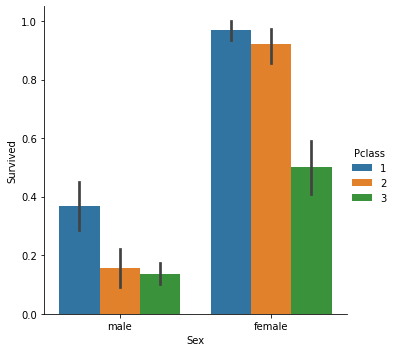

In [ ]:
# La altura de cada barra representa el valor medio de cada categoría
# Cada barra esta mostrando el valor medio respecto de si sobrevivieron o no (1 o 0) para varones y mujeres por cada clase de pasajero (Pclass)
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic_train);

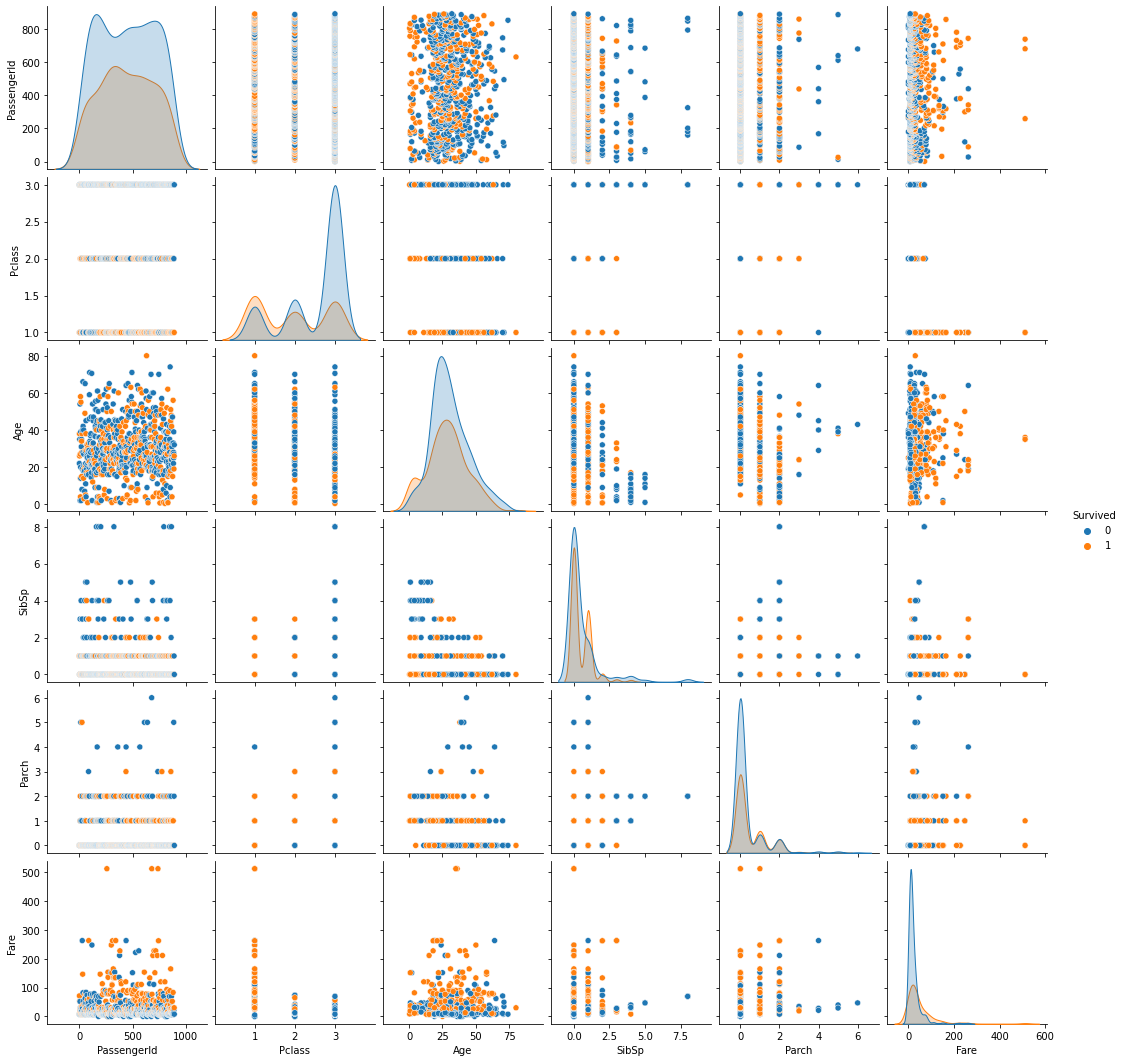

In [ ]:
sns.pairplot(titanic_train, hue="Survived");

## Preparación de los datos

`Pandas` nos permite seleccionar una columna como índice. En nuestro caso el índice es conveniente hacerlo con la columna `PassengerId`.

In [ ]:
titanic_train.set_index('PassengerId', inplace=True)
titanic_test.set_index('PassengerId', inplace=True)

In [ ]:
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
titanic_train.shape, titanic_test.shape

((891, 11), (418, 10))

### Lidiando con los valores faltantes

Usando un simple conteo en el conjunto de entrenamiento, podemos verificar que falta algunos valores para `Embarked`, `Age` y sobre todo `Cabin`.

In [ ]:
titanic_train.count()

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

En el conjunto de prueba, vemos que falta también un dato en `Fare`:

In [ ]:
titanic_test.count()

Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Ticket      418
Fare        417
Cabin        91
Embarked    418
dtype: int64

Hay diversas maneras de lidiar con valores faltantes. En este ejercicio haremos las siguientes opciones:

* `Embarked`: Sólo falta dos valores en el conjunto de entrenamiento. Imputaremos la moda (valor más frecuente).

In [ ]:
# Sólo hay dos valores faltantes NaN. La moda (valor más frecuente) es 'S'
titanic_train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [ ]:
# Registramos el índice (PassengerId) de los dos casos, y luego mostramos ambos registros
embarked_NaN = titanic_train[titanic_train['Embarked'].isnull()].index

print('Los PassengerId en los que falta Embarked son: ', embarked_NaN.values)

Los PassengerId en los que falta Embarked son:  [ 62 830]


In [ ]:
titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
# Calculamos la moda
embarked_moda = titanic_train['Embarked'].mode()[0]

print("La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es: ", embarked_moda)

La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es:  S


In [ ]:
# Imputamos la moda en los valores faltantes
titanic_train.loc[embarked_NaN, 'Embarked'] = embarked_moda

titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


* `Age`: Incluiremos un campo booleano de `EdadDesconocida` y adicionalmente completaremos el valor con la mediana.

In [ ]:
# Creamos una columna para caracterizar los casos con edad desconocida
titanic_train['EdadDesconocida'] = titanic_train['Age'].isnull()
titanic_test['EdadDesconocida'] = titanic_test['Age'].isnull()

In [ ]:
# Calculamos la mediana de Age y la imputamos en los valores faltantes de ambos conjuntos
age_mediana = titanic_train['Age'].median()

print("La mediana del campo Age en el conjunto de entrenamiento es: ", age_mediana)

La mediana del campo Age en el conjunto de entrenamiento es:  28.0


In [ ]:
# Mostramos cómo hacerlo con DataFrame.fillna()
titanic_train['Age'].fillna(age_mediana, inplace=True)
titanic_test['Age'].fillna(age_mediana, inplace=True)

* `Fare`: Un solo caso, en el conjunto de prueba. Imputaremos la mediana del conjunto de entrenamiento.

In [ ]:
fare_mediana = titanic_train['Fare'].median()

print("La mediana del campo Fare en el conjunto de entrenamiento es: ", fare_mediana)

La mediana del campo Fare en el conjunto de entrenamiento es:  14.4542


In [ ]:
titanic_test['Fare'].fillna(fare_mediana, inplace=True)

* `Cabin`: No usaremos la clase `Cabin`, severamente incompleta.

In [ ]:
titanic_train.drop(['Cabin'], axis=1, inplace=True)
titanic_test.drop(['Cabin'], axis=1, inplace=True)

### Selección de características

Ya hemos retirado la columna `Cabin`, severamente incompleta. Retiraremos también `Name` y `Ticket`, por ser campos irrelevantes para efectos de la predicción.

In [ ]:
titanic_train.drop(['Name','Ticket'], axis=1, inplace=True)
titanic_test.drop(['Name','Ticket'], axis=1, inplace=True)

Podemos añadir otras meta-características. Por ejemplo, podríamos crear una columna `ViajaSolo` cuando no el pasajero no viajó  con ningún familiar: 0 `SibSp` (viaja con hermanos o cónyuge) y 0 `Parch` (viaja con padres o hijos).

In [ ]:
titanic_train['ViajaSolo'] = ((titanic_train['SibSp'] + titanic_train['Parch']) == 0)
titanic_test['ViajaSolo'] = ((titanic_test['SibSp'] + titanic_test['Parch']) == 0)

In [ ]:
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False,False
2,1,1,female,38.0,1,0,71.2833,C,False,False
3,1,3,female,26.0,0,0,7.9250,S,False,True
4,1,1,female,35.0,1,0,53.1000,S,False,False
5,0,3,male,35.0,0,0,8.0500,S,False,True


In [ ]:
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,False,True
893,3,female,47.0,1,0,7.0000,S,False,False
894,2,male,62.0,0,0,9.6875,Q,False,True
895,3,male,27.0,0,0,8.6625,S,False,True
896,3,female,22.0,1,1,12.2875,S,False,False


Añade las columnas `MenorDeEdad` y `AdultoMayor`. Considera como menor de edad a todos aquellos menores de 18.0 años. Considera Adulto Mayor a los mayores de 55.0 años. Hazlo tanto en el conjunto de entrenamiento como en el de pruebas.

In [ ]:
titanic_train['MenorDeEdad'] = (titanic_train['Age'] < 18.0)
titanic_test['MenorDeEdad'] = (titanic_test['Age'] < 18.0)

titanic_train['AdultoMayor'] = (titanic_train['Age'] > 55.0)
titanic_test['AdultoMayor'] = (titanic_test['Age'] > 55.0)

**Pregunta 3:** ¿Cuántos menores de edad hay en el conjunto de entrenamiento?

**Pregunta 3:** ...

**Pregunta 4:** ¿Cuántos adultos mayores hay en el conjunto de pruebas?

**Pregunta 4:** ...

### Codificación de variables categóricas

Tenemos también tres variables categóricas (`Sex`, `Pclass` y `Embarked`). Las convertiremos en datos numéricos para que facilitar su entrenamiento por cualquier modelo.

* `Sex`: la podemos reemplazar por un valor binario `EsMujer` (0 = hombre; 1 = mujer).

In [ ]:
titanic_train['EsMujer'] = (titanic_train['Sex'] == 'female')
titanic_test['EsMujer'] = (titanic_test['Sex'] == 'female')

titanic_train.drop(['Sex'], axis=1, inplace=True)
titanic_test.drop(['Sex'], axis=1, inplace=True)

* `Pclass` y `Embarked`: Usaremos *one-hot encoding* con la función `DataFrame.get_dummies` de `pandas`.

  `Pclass` es la clase en la que viajó el pasajero (1 = primera clase; 2 = segunda clase; 3 = tercera clase).

  `Embarked` es el puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton).

  Observa que `Pclass` es categórica no obstante haya sido representada con una codificación numérica.

In [ ]:
cols_categoricas = ['Pclass','Embarked']

titanic_train = pd.get_dummies(titanic_train, columns=cols_categoricas)
titanic_test = pd.get_dummies(titanic_test, columns=cols_categoricas)

In [ ]:
titanic_train.head()

,Survived,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,False,False,False,0,0,1,0,0,1
2,1,38.0,1,0,71.2833,False,False,False,False,True,1,0,0,1,0,0
3,1,26.0,0,0,7.9250,False,True,False,False,True,0,0,1,0,0,1
4,1,35.0,1,0,53.1000,False,False,False,False,True,1,0,0,0,0,1
5,0,35.0,0,0,8.0500,False,True,False,False,False,0,0,1,0,0,1


In [ ]:
titanic_test.head()

,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,False,True,False,False,False,0,0,1,0,1,0
893,47.0,1,0,7.0000,False,False,False,False,True,0,0,1,0,0,1
894,62.0,0,0,9.6875,False,True,False,True,False,0,1,0,0,1,0
895,27.0,0,0,8.6625,False,True,False,False,False,0,0,1,0,0,1
896,22.0,1,1,12.2875,False,False,False,False,True,0,0,1,0,0,1


## Separación de conjunto para validación

In [ ]:
X_train_val = titanic_train.drop('Survived', axis=1)
y_train_val = titanic_train['Survived']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

## Entrenamiento de Random Forests

Probemos primero entrenando un modelo Random Forest con los parámetros que trae por defecto.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print('Exactitud del modelo inicial en entrenamiento:', model.score(X_train, y_train))
print('Exactitud del modelo inicial en validación:', model.score(X_val, y_val))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', model.oob_score_)

Exactitud del modelo inicial en entrenamiento: 0.9817415730337079
Exactitud del modelo inicial en validación: 0.8156424581005587
Exactitud del modelo inicial en entrenamiento (Out of Bag): 0.7963483146067416


### Búsqueda aleatoria de hiperparámetros

El clasificador de Random Forest tiene diversos parámetros que pueden ser optimizados. Se puede ver la documentación de [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Los principales hiperparámetros de Random Forest son:
- `n_estimators` -- el número de modelos base (árboles) a entrenar
- `max_features` -- el número de características a considerar en cada partición de los árboles
- `max_depth` -- la profundidad máxima de los árboles
- `min_samples_leaf` -- el numero mínimo de muestras que deben quedar en cada hoja del árbol

Para identificar los mejores valores de los hiperparámetros usaremos primero búsqueda aleatoria y luego búsqueda en grilla.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from pprint import pprint

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

Los valores a probar en la búsqueda aleatoria son:
{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
print('Si se probara todas las combinaciones se requeriría entrenar {} modelos'.format(len(random_grid['n_estimators']) *
                                                                                       len(random_grid['max_features']) *
                                                                                       len(random_grid['max_depth']) *
                                                                                       len(random_grid['min_samples_leaf'])))

Si se probara todas las combinaciones se requeriría entrenar 1800 modelos


Probaremos entrenando sólo un 2% de las combinaciones posibles, es decir, 36. (Se recomienda probar al menos un 10%)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(oob_score=True)

model_random = RandomizedSearchCV(estimator=model,
                                  param_distributions=random_grid,
                                  n_iter=36,     # Cada iteración representa un nuevo modelo entrenado en una nueva combinación del diccionario de hiperparámetros.
                                  cv=3,          # Validación cruzada 3-fold
                                  verbose=2,
                                  random_state=0,
                                  n_jobs=-1      # Paralelizar en todos los cores disponibles
                                )

model_random.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
model_random_best = model_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(model_random.best_params_)

Los hiperparámetros del mejor modelo son:
{'max_depth': 70,
 'max_features': 10,
 'min_samples_leaf': 4,
 'n_estimators': 400}


In [ ]:
print('Exactitud luego de búsqueda aleatoria en entrenamiento:', model_random_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', model_random_best.score(X_val, y_val))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', model_random_best.oob_score_)

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8862359550561798
Exactitud luego de búsqueda aleatoria en validación: 0.8379888268156425
Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag): 0.8286516853932584


In [ ]:
max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

second_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
print('Los valores a probar en la búsqueda por grilla son:')
pprint(second_grid)

Los valores a probar en la búsqueda por grilla son:
{'max_depth': [57, 60, 63],
 'max_features': [9, 10, 11],
 'min_samples_leaf': [4],
 'n_estimators': [1200]}


In [ ]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(oob_score=True)
model_grid = GridSearchCV(estimator=model,
                          param_grid=second_grid,
                          cv=3,          # Validación cruzada 3-fold
                          verbose=2,
                          n_jobs=-1      # Paralelizar en todos los cores disponibles
                        )

model_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   50.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                                 

In [ ]:
model_grid_best = model_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(model_grid.best_params_)

Los hiperparámetros del mejor modelo son:
{'max_depth': 57,
 'max_features': 10,
 'min_samples_leaf': 4,
 'n_estimators': 1200}


In [ ]:
print('Exactitud luego de búsqueda en grilla en entrenamiento:', model_grid_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en validación:', model_grid_best.score(X_val, y_val))
print('Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag):', model_grid_best.oob_score_)

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8904494382022472
Exactitud luego de búsqueda en grilla en validación: 0.8435754189944135
Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag): 0.8188202247191011


### Curva ROC

In [ ]:
y_pred_val = model_grid_best.predict_proba(X_val)[:,1]

In [ ]:
from sklearn import metrics

auc_roc = metrics.roc_auc_score(y_val, y_pred_val)

print('AUC =', auc_roc)

AUC = 0.8971014492753625


<Figure size 432x288 with 0 Axes>

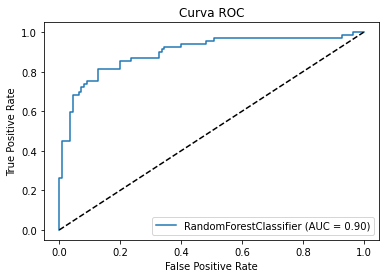

In [ ]:
plt.figure(figsize=(6,4))

metrics.plot_roc_curve(model_grid_best, X_val, y_val)
plt.plot([0,1], [0,1], 'k--' )

plt.title("Curva ROC")

plt.show()

## Visualización de las características más importantes



In [ ]:
feature_names = X_train.columns.values
tree_feature_importances = model_grid_best.feature_importances_
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))

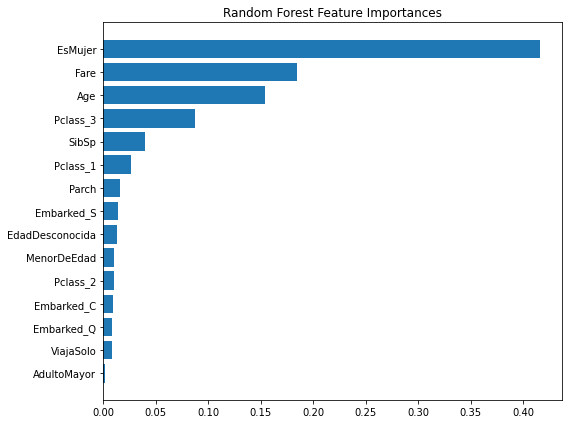

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.barh(y_ticks, tree_feature_importances[sorted_idx])

ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)

ax.set_title("Random Forest Feature Importances")

fig.tight_layout()

plt.show()

# [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) ([ejemplos](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py)\)

In [ ]:
max_depth = range(50, 60)
learning_rate = [0.4, 0.45, 0.5, 0.55, 0.6]
n_estimators = range(100, 150, 10)

xgboost_grid = {'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth}

In [ ]:
print('Los valores a probar en la búsqueda por grilla son:')
pprint(xgboost_grid)

Los valores a probar en la búsqueda por grilla son:
{'learning_rate': [0.4, 0.45, 0.5, 0.55, 0.6],
 'max_depth': range(50, 60),
 'n_estimators': range(100, 150, 10)}


In [ ]:
from xgboost.sklearn import XGBClassifier

model = XGBClassifier()
model_grid = GridSearchCV(estimator=model,
                          param_grid=second_grid,
                          cv=3,          # Validación cruzada 3-fold
                          verbose=2,
                          n_jobs=-1      # Paralelizar en todos los cores disponibles
                        )

model_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [57, 60, 63], 'max_features': [9, 10, 11],
                         'min_samples_leaf': [4], 'n_estimators': [1200]},
             pre_dispat

In [ ]:
model_grid_best = model_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(model_grid.best_params_)

Los hiperparámetros del mejor modelo son:
{'max_depth': 57,
 'max_features': 9,
 'min_samples_leaf': 4,
 'n_estimators': 1200}


In [ ]:
print('Exactitud luego de búsqueda en grilla en entrenamiento:', model_grid_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en validación:', model_grid_best.score(X_val, y_val))

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9817415730337079
Exactitud luego de búsqueda en grilla en validación: 0.8324022346368715


# Otros modelos de ensamble

Prueba a entrenar ensambles con por lo menos otras dos [estrategias](https://scikit-learn.org/stable/modules/ensemble.html#). Puedes intentar, por ejemplo, con [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) o [Stacked](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization). Tal como se muestra a continuación con XGBoost.